# Checklist
1.   Data Acquisition & Sampling ✅
2.   Data Labeling ✅
3.   Data Preprocessing & Wrangling ✅
4.   EDA ✅
5.   Features Engineering and Selections ✅
6.   IDPS Model Development ✅
7.   Ensemble ✅
8.   Hyperparameter Tuning ✅
9.   Model Evaluation ✅
10.  Unseen, Real Industrial Data Evaluation (Test Rare and Unseen Sample) ✅
11.  Dashboard Building
12.  Paper Writing



# 0 Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sn

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import math
import os
import sys
import json
import itertools
import joblib
import pickle
from time import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, model_from_json
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy
from keras.optimizers.legacy import SGD
from keras.utils import plot_model

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# 1) Data Acquisition & Sampling

In [ ]:
# Sampled Data
multiattack_dataset = pd.read_csv("./gdrive/MyDrive/backups_data/multiattack_dataset.csv")
multiattack_dataset['first_timestamp'] = pd.to_datetime(multiattack_dataset['first_timestamp'])
multiattack_dataset['last_timestamp'] = pd.to_datetime(multiattack_dataset['last_timestamp'])

In [ ]:
# Sampled and Cleaned Data
training_multiattack_dataset = pd.read_csv('./gdrive/MyDrive/backups_data/cleaned_multiattack_dataset.csv')
training_multiattack_dataset['first_timestamp'] = pd.to_datetime(training_multiattack_dataset['first_timestamp'])
training_multiattack_dataset['last_timestamp'] = pd.to_datetime(training_multiattack_dataset['last_timestamp'])

In [ ]:
#Sampled, Cleaned, and Feature Generated Data
whole_all_feat = pd.read_csv('./gdrive/MyDrive/backups_data/gen_feat_multiattack_dataset.csv')

In [ ]:
traffic = pd.read_csv("./gdrive/MyDrive/vhs-22-network-traffic-dataset.csv", sep=';')

In [ ]:
length_of_data = len(traffic)

#To extract only 1 million data as a small scale training for my model
fraction = float(1000000/length_of_data)

#Follow the sequence of columns to better understand the data
#Flow-level information: source and destination IP addresses, source and destination ports, protocols, length of flow expressed in packets, and timestamps of the first and last packet in a flow, TCP, IAT
#Network-level:  total number of connections to/from a given host, or ratios of connection to/from a given host against the total number of active flows
columns = ["ip_src_str", "ip_dst_str", "ip_protocol", "sport", "dport", "in_packets",
          "b_packet_total", "first_timestamp", "last_timestamp", "duration", "flags_sum",
          "urg_nr_count", "ack_nr_count", "rst_nr_count", "fin_nr_count", "psh_nr_count", "syn_nr_count",
          "b_packet_max", "b_packet_min", "b_packet_mean", "b_packet_median", "b_packet_first_q",
          "b_packet_third_q", "b_packet_std", "iat_min", "iat_max", "iat_first_q",
          "iat_third_q", "iat_std", "iat_mean", "iat_median", "iat_var",
           "connections_from_this_host", "connections_to_this_host", "connections_rst_to_this_host",
           "connections_rst_from_this_host", "connections_to_this_port", "connections_from_this_port",
          "connections_ratio_from_this_host", "connections_ratio_to_this_host", "connections_ratio_rst_to_this_host",
          "connections_ratio_rst_from_this_host", "connections_ratio_to_this_port", "connections_ratio_from_this_port",
          "label", "attack_label", "attack_file"]

In [ ]:
traffic = traffic.reindex(columns=columns)

to_drop = ['connections_ratio_rst_from_this_host', #0 values, meaningless
           'connections_rst_from_this_host', #0 values, meaningless
           'iat_third_q', #0 values, meaningless
           'iat_first_q', #0 values, meaningless
           "urg_nr_count", #covered by flags_sum
          "ack_nr_count", #covered by flags_sum
          "rst_nr_count", #covered by flags_sum
          "fin_nr_count", #covered by flags_sum
          "psh_nr_count", #covered by flags_sum
          "syn_nr_count", #covered by flags_sum
          ]

traffic.drop(to_drop, inplace = True, axis=1)

traffic.sort_values(by=['first_timestamp'], inplace=True)

traffic.head()

,ip_src_str,ip_dst_str,ip_protocol,sport,dport,in_packets,b_packet_total,first_timestamp,last_timestamp,duration,flags_sum,b_packet_max,b_packet_min,b_packet_mean,b_packet_median,b_packet_first_q,b_packet_third_q,b_packet_std,iat_min,iat_max,iat_std,iat_mean,iat_median,iat_var,connections_from_this_host,connections_to_this_host,connections_rst_to_this_host,connections_to_this_port,connections_from_this_port,connections_ratio_from_this_host,connections_ratio_to_this_host,connections_ratio_rst_to_this_host,connections_ratio_to_this_port,connections_ratio_from_this_port,label,attack_label,attack_file
0,131.243.61.70,239.255.255.253,17,59666,427,4,364,2022-01-01 00:00:00.002448,2022-01-01 00:00:09.004970,9.002522,0,91,91,91.0,91.0,91,91,0.000000,3.000550,3.001299,0.000328,3.000841,3.001299,1.076142e-07,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0,NORMAL,isot
1,128.3.164.249,128.3.97.204,17,45308,53,1,88,2022-01-01 00:00:00.016580,2022-01-01 00:00:00.016580,0.000000,0,88,88,88.0,88.0,88,88,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0,NORMAL,isot
2,220.195.34.143,128.3.23.41,6,80,5834,1,66,2022-01-01 00:00:00.024558,2022-01-01 00:00:00.024558,0.000000,16,66,66,66.0,66.0,66,66,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0,NORMAL,isot
3,220.195.34.143,128.3.23.41,6,80,5836,4,468,2022-01-01 00:00:00.025059,2022-01-01 00:00:00.108634,0.083575,17,258,66,117.0,258.0,78,78,81.553665,0.000125,0.082334,0.038522,0.027858,0.000125,1.483965e-03,14,15,0,0,31,0.112903,0.120968,0.0,0.0,0.250000,0,NORMAL,isot
4,220.195.34.143,128.3.23.41,6,80,5835,1,66,2022-01-01 00:00:00.026183,2022-01-01 00:00:00.026183,0.000000,16,66,66,66.0,66.0,66,66,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28,31,0,0,114,0.055888,0.061876,0.0,0.0,0.227545,0,NORMAL,isot


In [ ]:
#Stratified Sample with consideration to include 115 types of attacks.
multiattack_dataset = traffic.groupby('attack_label', group_keys=False).apply(lambda x: x.sample(frac=fraction))
multiattack_dataset = multiattack_dataset.reindex(columns=columns)
multiattack_dataset.sort_values(by=['first_timestamp'], inplace=True)
multiattack_dataset.to_csv('./gdrive/MyDrive/backups_data/multiattack_dataset.csv')

In [ ]:
#Overview of population characteristics
traffic.describe()

,ip_protocol,sport,dport,in_packets,b_packet_total,duration,flags_sum,urg_nr_count,ack_nr_count,rst_nr_count,fin_nr_count,psh_nr_count,syn_nr_countb_packet_max,b_packet_min,b_packet_mean,b_packet_median,b_packet_first_q,b_packet_third_q,b_packet_std,b_packet_total,iat_min,iat_max,iat_first_q,iat_third_q,iat_std,iat_mean,iat_median,iat_var,connections_from_this_host,connections_to_this_host,connections_rst_to_this_host,connections_rst_from_this_host,connections_to_this_port,connections_from_this_port,connections_ratio_from_this_host,connections_ratio_to_this_host,connections_ratio_rst_to_this_host,connections_ratio_rst_from_this_host,connections_ratio_to_this_port,connections_ratio_from_this_port,label
count,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,0.0,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,27735675.0,27735675.0,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,27735675.0,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,2.773568e+07,27735675.0,2.773568e+07,2.773568e+07,2.773568e+07
mean,1.281092e+01,1.743195e+04,2.374933e+04,2.599812e+01,1.924826e+04,4.925924e+03,6.498711e+00,3.160046e-03,2.026148e+01,7.808802e-02,1.945019e-01,3.885235e+00,NaN,2.894888e+02,3.707951e+02,3.480426e+02,3.007267e+02,3.007267e+02,8.498138e+01,1.924826e+04,9.520364e+02,4.016060e+03,0.0,0.0,8.440344e+02,1.437204e+03,1.570035e+02,8.864943e+08,2.954720e+01,9.016250e+01,2.312753e+01,0.0,2.776191e+01,8.004166e+01,7.614275e-02,2.304044e-01,5.039996e-02,0.0,7.335162e-02,2.097922e-01,2.666340e-01
std,5.341487e+00,2.239148e+04,2.255669e+04,4.044300e+03,3.121975e+06,1.389616e+05,1.279380e+01,7.052764e-01,3.997504e+03,2.683101e-01,3.958168e-01,8.910656e+02,NaN,4.857120e+02,5.289403e+02,6.076129e+02,4.903435e+02,4.903435e+02,2.944873e+02,3.121975e+06,5.649932e+04,1.241845e+05,0.0,0.0,2.976209e+04,5.983660e+04,8.455821e+03,6.255200e+10,8.103529e+01,1.723558e+02,1.260707e+02,0.0,7.166904e+01,1.605717e+02,1.756657e-01,3.606826e-01,2.566366e-01,0.0,1.630096e-01,3.423469e-01,4.421994e-01
min,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,4.400000e+01,4.400000e+01,0.000000e+00,4.400000e+01,4.400000e+01,0.000000e+00,4.400000e+01,-3.613304e+03,-1.678944e-03,0.0,0.0,0.000000e+00,-1.774153e+00,-4.772279e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,5.300000e+01,4.430000e+02,1.000000e+00,8.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,6.000000e+01,6.806250e+01,6.000000e+01,6.200000e+01,6.200000e+01,0.000000e+00,8.100000e+01,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.700000e+01,2.513000e+03,1.336300e+04,1.000000e+00,2.420000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,7.400000e+01,1.030000e+02,7.700000e+01,7.500000e+01,7.500000e+01,0.000000e+00,2.420000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.984032e-03,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+01,3.843900e+04,4.697800e+04,5.000000e+00,1.514000e+03,5.442859e+00,1.700000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.330000e+02,3.162222e+02,2.130000e+02,1.440000e+02,1.440000e+02,6.000000e+00,1.514000e+03,1.571178e-04,3.909783e+00,0.0,0.0,7.970088e-02,

In [ ]:
#To make sure the characteristics of the sampled data is similar to the population
multiattack_dataset.describe()

#in_packets mean and max value
#b_packet_total mean, std, max value = skewed a little bit
#duration mean, std, max value = skewed a little bit
#flags_sum mean, std, max value = skewed a little bit
#b_packet_mean max value
#b_packet_median 75% value
#b_packet_first_q max value
#b_packet_third_q max value
#iat_max min value
#iat_mean min value significant skewed by half
#iat_median mean std min significant skewed

,Unnamed: 0,ip_protocol,sport,dport,in_packets,b_packet_total,duration,flags_sum,urg_nr_count,ack_nr_count,rst_nr_count,fin_nr_count,psh_nr_count,syn_nr_count,b_packet_max,b_packet_min,b_packet_mean,b_packet_median,b_packet_first_q,b_packet_third_q,b_packet_std,iat_min,iat_max,iat_first_q,iat_third_q,iat_std,iat_mean,iat_median,iat_var,connections_from_this_host,connections_to_this_host,connections_rst_to_this_host,connections_rst_from_this_host,connections_to_this_port,connections_from_this_port,connections_ratio_from_this_host,connections_ratio_to_this_host,connections_ratio_rst_to_this_host,connections_ratio_rst_from_this_host,connections_ratio_to_this_port,connections_ratio_from_this_port,label
count,9.999990e+05,999999.000000,999999.000000,999999.000000,9.999990e+05,9.999990e+05,9.999990e+05,999999.000000,999999.000000,9.999990e+05,999999.000000,999999.000000,9.999990e+05,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,9.999990e+05,9.999990e+05,999999.0,999999.0,9.999990e+05,9.999990e+05,9.999990e+05,9.999990e+05,999999.000000,999999.000000,999999.000000,999999.0,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.0,999999.000000,999999.000000,999999.000000
mean,1.386406e+07,12.808325,17448.438837,23741.619410,2.544900e+01,1.921758e+04,4.836625e+03,6.499149,0.003208,1.931216e+01,0.078316,0.194711,4.263887e+00,0.282719,519.280151,289.505361,370.723832,348.313823,300.617745,300.617745,84.798274,1.003522e+03,3.960090e+03,0.0,0.0,8.032176e+02,1.453690e+03,1.476761e+02,7.987318e+08,29.554498,90.140697,23.105182,0.0,27.744695,80.134915,0.076148,0.230551,0.050400,0.0,0.073394,0.209999,0.266633
std,8.006204e+06,5.342126,22402.879119,22551.718166,2.458542e+03,2.432049e+06,1.355144e+05,12.756290,0.378814,2.400625e+03,0.268668,0.395978,1.068933e+03,0.600281,850.641531,485.785678,528.980893,608.767822,490.297405,490.297405,294.253932,5.824162e+04,1.225352e+05,0.0,0.0,2.825044e+04,6.091216e+04,6.596033e+03,5.834251e+10,80.994132,172.380433,126.079562,0.0,71.603928,160.675811,0.175563,0.360668,0.256683,0.0,0.163000,0.342454,0.442199
min,3.900000e+01,6.000000,0.000000,0.000000,1.000000e+00,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,44.000000,44.000000,44.000000,0.000000,44.000000,44.000000,0.000000,-3.434243e+03,-2.739429e-04,0.0,0.0,0.000000e+00,-2.755682e-03,-6.000881e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,6.930182e+06,6.000000,53.000000,443.000000,1.000000e+00,8.100000e+01,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,72.000000,60.000000,68.000000,60.000000,62.000000,62.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.386049e+07,17.000000,2504.000000,13363.000000,1.000000e+00,2.420000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,108.000000,74.000000,103.000000,77.000000,75.000000,75.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.007984,0.000000,0.0,0.000000,0.000000,0.000000
75%,2.079597e+07,17.000000,38499.000000,46951.000000,5.000000e+00,1.514000e+03,5.413425e+00,17.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,700.000000,133.000000,316.500000,214.000000,144.000000,144.000000,5.878776,1.587868e-04,3.878519e+00,0.0,0.0,7.949830e-02,7.594164e-01,2.150536e-04,6.319980e-03,10.000000,65.000000,0.000000,0.0,1.000000,58.000000,0.043912,0.313373,0.000000,0.0,0.015968,0.303393,1.000000
max,2.773565e+07,17.000000,65535.000000,65535.000000,1.204849e+06,1.386523e+09,8.241694e+06,255.000000,364.000000,1.204849e+06,1.000000,1.000000,1.01301

# 2) Data Labeling

In [ ]:
(traffic['label'].value_counts()) / len(traffic) * 100

0    73.3366
1    26.6634
Name: label, dtype: float64

In [ ]:
(multiattack_dataset['label'].value_counts()) / len(multiattack_dataset) * 100

0    73.336673
1    26.663327
Name: label, dtype: float64

# 3) Data Cleaning

In [ ]:
multiattack_dataset.head()

,Unnamed: 0,ip_src_str,ip_dst_str,ip_protocol,sport,dport,in_packets,b_packet_total,first_timestamp,last_timestamp,duration,flags_sum,urg_nr_count,ack_nr_count,rst_nr_count,fin_nr_count,psh_nr_count,syn_nr_count,b_packet_max,b_packet_min,b_packet_mean,b_packet_median,b_packet_first_q,b_packet_third_q,b_packet_std,iat_min,iat_max,iat_first_q,iat_third_q,iat_std,iat_mean,iat_median,iat_var,connections_from_this_host,connections_to_this_host,connections_rst_to_this_host,connections_rst_from_this_host,connections_to_this_port,connections_from_this_port,connections_ratio_from_this_host,connections_ratio_to_this_host,connections_ratio_rst_to_this_host,connections_ratio_rst_from_this_host,connections_ratio_to_this_port,connections_ratio_from_this_port,label,attack_label,attack_file
0,39,131.243.127.130,128.3.97.204,17,3261,53,1,81,2022-01-01 00:00:00.274659,2022-01-01 00:00:00.274659,0.000000,0,0,0,0,0,0,0,81,81,81.000000,81.0,81,81,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,0,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,NORMAL,isot
1,85,131.243.102.137,239.255.255.253,17,54841,427,2,182,2022-01-01 00:00:00.902650,2022-01-01 00:00:07.900767,6.998117,0,0,0,0,0,0,0,91,91,91.000000,0.0,91,91,0.000000,6.998117,6.998117,0,0,0.000000,6.998117,0.000000,0.000000e+00,0,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,NORMAL,isot
2,105,128.3.23.124,128.3.71.91,6,731,897,1,66,2022-01-01 00:00:01.019182,2022-01-01 00:00:01.019182,0.000000,16,0,1,0,0,0,0,66,66,66.000000,66.0,66,66,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,0,22,0,0,13,0,0.000000,0.043912,0.0,0.0,0.025948,0.000000,0,NORMAL,isot
3,118,128.3.23.3,128.3.71.91,6,788,111,5,398,2022-01-01 00:00:01.055785,2022-01-01 00:00:01.056664,0.000879,17,0,4,0,1,1,1,126,66,79.599998,66.0,74,74,23.405983,0.000005,0.000500,0,0,0.000184,0.000220,0.000500,3.368198e-08,15,24,0,0,10,0,0.086705,0.138728,0.0,0.0,0.057803,0.000000,0,NORMAL,isot
4,119,128.3.71.91,128.3.23.3,6,111,788,4,304,2022-01-01 00:00:01.055932,2022-01-01 00:00:01.056935,0.001003,17,0,4,0,1,1,1,98,66,76.000000,98.0,74,74,13.114877,0.000251,0.000378,0,0,0.000059,0.000334,0.000378,3.471478e-09,24,15,0,0,0,10,0.137931,0.086207,0.0,0.0,0.000000,0.057471,0,NORMAL,isot


In [ ]:
#Data Cleaning and Wrangling
training_multiattack_dataset = multiattack_dataset.copy()

#Data type conversion of timestamp data from string to datetime64[ns]
training_multiattack_dataset['first_timestamp'] = pd.to_datetime(training_multiattack_dataset['first_timestamp'])
training_multiattack_dataset['last_timestamp'] = pd.to_datetime(training_multiattack_dataset['last_timestamp'])

In [ ]:
#Format Revision
print(training_multiattack_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 49 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   Unnamed: 0.1                          999999 non-null  int64         
 1   Unnamed: 0                            999999 non-null  int64         
 2   ip_src_str                            999999 non-null  object        
 3   ip_dst_str                            999999 non-null  object        
 4   ip_protocol                           999999 non-null  int64         
 5   sport                                 999999 non-null  int64         
 6   dport                                 999999 non-null  int64         
 7   in_packets                            999999 non-null  int64         
 8   b_packet_total                        999999 non-null  int64         
 9   first_timestamp                       999999 non-null  date

In [ ]:
print("""
Based on the info from the DataFrame,
   1) Data type is converted to correct form
   2) No null value
   3) Duplication not checked. It's common to have duplicated pattern in network flow
   4) Outliers not checked. It's common that outliers are anomaly that may result in threat
""")


Based on the info from the DataFrame, 
   1) Data type is converted to correct form
   2) No null value
   3) Duplication not checked. It's common to have duplicated pattern in network flow
   4) Outliers not checked. It's common that outliers are anomaly that may result in threat



In [ ]:
#save cleaned data
training_multiattack_dataset.to_csv('./gdrive/MyDrive/backups_data/multiattack_dataset.csv')

# 4) EDA

1.   See distribution of attack in traffic and multiattack


In [ ]:
#EDA
nominals = ["ip_src_str", "ip_dst_str", "ip_protocol", "sport", "dport", "first_timestamp",
           "last_timestamp", "flags_sum", "urg_nr_count", "ack_nr_count", "rst_nr_count",
            "fin_nr_count", "psh_nr_count", "syn_nr_count", "label", "attack_label", "attack_file"]

interval = ["in_packets", "b_packet_total", "duration", "b_packet_max", "b_packet_min", "b_packet_mean",
           "b_packet_median", "b_packet_first_q", "b_packet_third_q", "b_packet_std",
           "b_packet_total", "iat_min", "iat_max", "iat_first_q", "iat_third_q",
           "iat_std", "iat_mean", "iat_median", "iat_var", "connections_from_this_host",
           "connections_to_this_host", "connections_rst_from_this_host",
           "connections_to_this_port", "connections_from_this_port", "connections_ratio_from_this_host",
           "connections_ratio_to_this_host", "connections_ratio_rst_to_this_host",
           "connections_ratio_to_this_port", "connections_ratio_from_this_port"]

interval = ["in_packets", "b_packet_total", "duration", "b_packet_max", "b_packet_min", "b_packet_mean",
           "b_packet_median", "b_packet_first_q", "b_packet_third_q", "b_packet_std",
           "b_packet_total", "iat_min", "iat_max", "iat_std", "iat_mean", "iat_median", "iat_var", "connections_from_this_host",
           "connections_to_this_host",
           "connections_to_this_port", "connections_from_this_port",
           "connections_ratio_to_this_host", "connections_ratio_rst_to_this_host",
           "connections_ratio_to_this_port", "connections_ratio_from_this_port"]

#Univariate non-graphical - Histogram to check distribution, boxplot see skewness

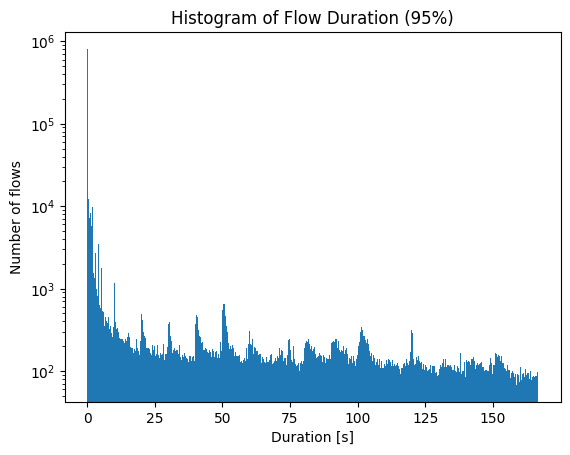

In [ ]:
fig1_data = training_multiattack_dataset[['duration']].where(training_multiattack_dataset['duration'] <= 10000)
plt.hist(fig1_data/60, bins=500)
tick_locations = np.linspace(1,1000000,8)
tick_labels = ['10^0', '10^1', '10^2', '10^3', '10^4', '10^5', '10^6', '10^7']
plt.yticks(tick_locations, tick_labels)
plt.yscale("log")
plt.xlabel("Duration [s]")
plt.ylabel("Number of flows")
plt.title("Histogram of Flow Duration (95%)")
plt.show()

In [ ]:
normal_traffic0 = training_multiattack_dataset['duration'].where(training_multiattack_dataset['label'] == 0).where(training_multiattack_dataset['duration'] == 0).count()
normal_traffic = training_multiattack_dataset['duration'].where(training_multiattack_dataset['label'] == 0).where(training_multiattack_dataset['duration'] > 0).count()
nom_total = normal_traffic+normal_traffic0
attack_traffic0 = training_multiattack_dataset['duration'].where(training_multiattack_dataset['label'] == 1).where(training_multiattack_dataset['duration'] == 0).count()
attack_traffic = training_multiattack_dataset['duration'].where(training_multiattack_dataset['label'] == 1).where(training_multiattack_dataset['duration'] > 0).count()
attack_total=attack_traffic+attack_traffic0
total=normal_traffic+normal_traffic0+attack_traffic+attack_traffic0

print("\t\tTable 1 :Flow Count Stats")
print("_______________________________________________________")
print("     Normal Traffic \t\t\t Attack")
print("Dur>0\t\tDur.=0 \t\t Dur>0\t\tDur.=0")
print("_______________________________________________________")
print(f"{normal_traffic}\t\t{normal_traffic0} \t\t {attack_traffic}\t\t{attack_traffic0}")
print(f"     {nom_total} ({round(nom_total/total*100)}%)\t\t     {attack_total} ({round(attack_total/total*100)}%)")
print(f"\t\t    Total:{total}")
print("_______________________________________________________")


		Table 1 :Flow Count Stats
_______________________________________________________
     Normal Traffic 			 Attack
Dur>0		Dur.=0 		 Dur>0		Dur.=0
_______________________________________________________
403559		329807 		 45044		221589
     733366 (73%)		     266633 (27%)
		    Total:999999
_______________________________________________________


In [ ]:
TCP_traffic0 = training_multiattack_dataset['duration'].where(training_multiattack_dataset['ip_protocol'] == 6).where(training_multiattack_dataset['duration'] == 0).count()
TCP_traffic = training_multiattack_dataset['duration'].where(training_multiattack_dataset['ip_protocol'] == 6).where(training_multiattack_dataset['duration'] > 0).count()
TCP_total = TCP_traffic+TCP_traffic0
UDP_traffic0 = training_multiattack_dataset['duration'].where(training_multiattack_dataset['ip_protocol'] == 17).where(training_multiattack_dataset['duration'] == 0).count()
UDP_traffic = training_multiattack_dataset['duration'].where(training_multiattack_dataset['ip_protocol'] == 17).where(training_multiattack_dataset['duration'] > 0).count()
UDP_total=UDP_traffic+UDP_traffic0
protocol_total=TCP_traffic+TCP_traffic0+UDP_traffic+UDP_traffic0

print("\t\tTable 2: Protocol Stats")
print("_______________________________________________________")
print("     TCP flows \t\t\t UDP flows")
print("Dur>0\t\tDur.=0 \t\t Dur>0\t\tDur.=0")
print("_______________________________________________________")
print(f"{TCP_traffic}\t\t{TCP_traffic0} \t\t {UDP_traffic}\t\t{UDP_traffic0}")
print(f"     {TCP_total} ({round(TCP_total/protocol_total*100)}%)\t\t     {UDP_total} ({round(UDP_total/protocol_total*100)}%)")
print(f"\t\t    Total:{protocol_total}")
print("_______________________________________________________")


		Table 2: Protocol Stats
_______________________________________________________
     TCP flows 			 UDP flows
Dur>0		Dur.=0 		 Dur>0		Dur.=0
_______________________________________________________
235919		145142 		 212684		406254
     381061 (38%)		     618938 (62%)
		    Total:999999
_______________________________________________________


In [ ]:
one_packet = training_multiattack_dataset['in_packets'].where(training_multiattack_dataset['in_packets'] == 1).count()
one_packet_normal = training_multiattack_dataset['in_packets'].where(training_multiattack_dataset['in_packets'] == 1).where(training_multiattack_dataset['label'] == 0).count()
one_packet_attack = training_multiattack_dataset['in_packets'].where(training_multiattack_dataset['in_packets'] == 1).where(training_multiattack_dataset['label'] == 1).count()

print("\tTable 3: Zero-Duration Flows (1-packet flow)")
print("_______________________________________________________")
print("     Normal Traffic \t\t\t Attack")
print("Pac.No.=1\tPac.No.>1 \t Pac.No.=1\tPac.No.>1")
print("_______________________________________________________")
print(f"{one_packet_normal}({round(one_packet_normal/nom_total*100)}%)\t{nom_total-one_packet_normal} \t\t {one_packet_attack}({round(one_packet_attack/attack_total*100)}%)\t{attack_total-one_packet_attack}")
print(f"\t  {nom_total}\t\t\t  {attack_total}")
print(f"\t\t    Total:{total}")
print("_______________________________________________________")



	Table 3: Zero-Duration Flows (1-packet flow)
_______________________________________________________
     Normal Traffic 			 Attack
Pac.No.=1	Pac.No.>1 	 Pac.No.=1	Pac.No.>1
_______________________________________________________
329540(45%)	403826 		 221564(83%)	45069
	  733366			  266633
		    Total:999999
_______________________________________________________


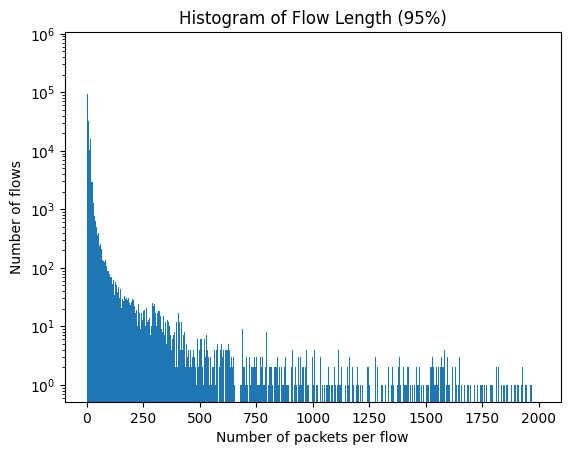

In [ ]:
#Distribution check - Histogram
x = training_multiattack_dataset['in_packets'].where(training_multiattack_dataset['in_packets'] <= 2000)
plt.hist(x, bins=2000)
tick_locations = np.linspace(1,10000,6)
tick_labels = ['10^0', '10^1', '10^2', '10^3', '10^4', '10^5']
plt.yticks(tick_locations, tick_labels)
plt.yscale('log')
plt.ylabel('Number of flows')
plt.xlabel('Number of packets per flow')
plt.title('Histogram of Flow Length (95%)')
plt.show()

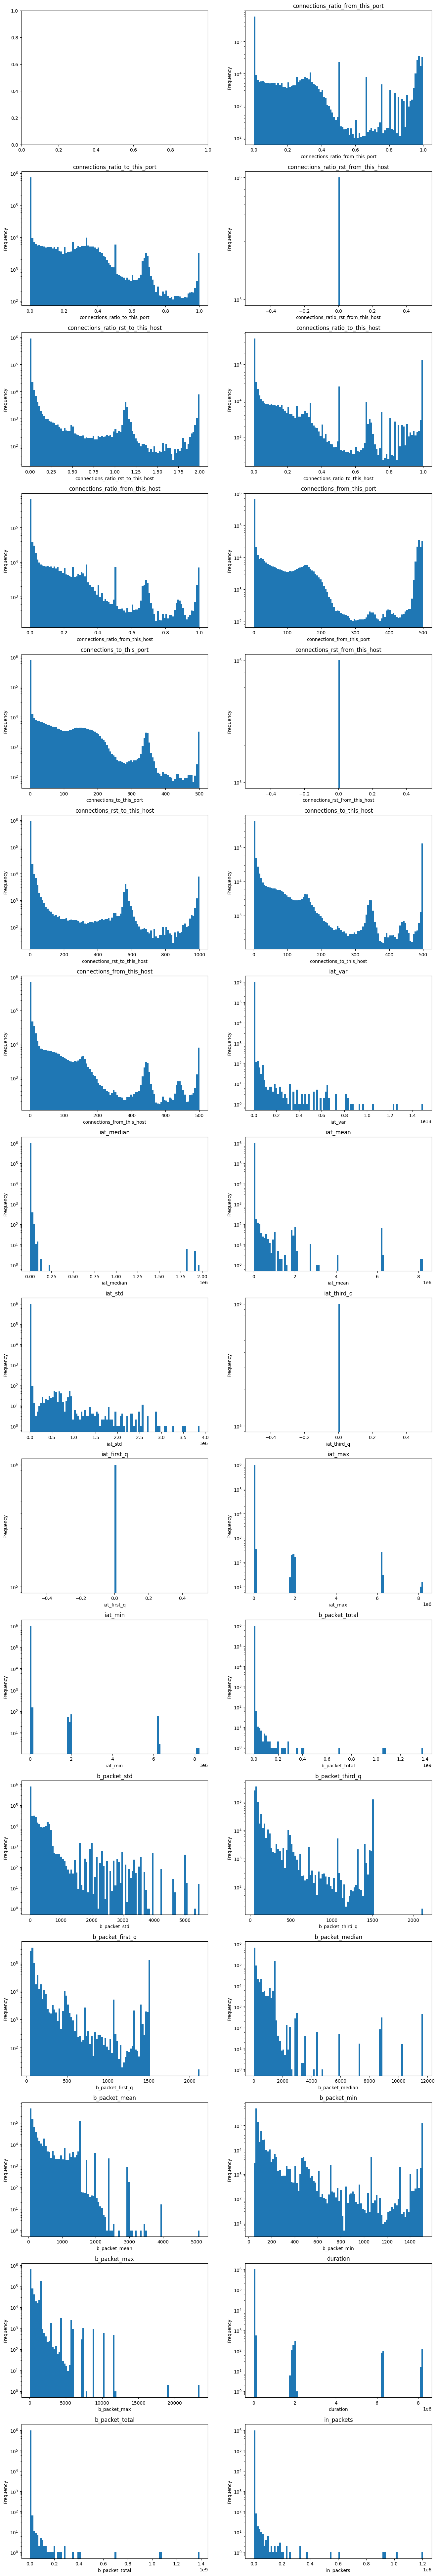

In [ ]:
fig, axs = plt.subplots(16,2,figsize=(16,100))
y_pos = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
x_pos = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15]
for col in interval:
  x = x_pos.pop()
  y = y_pos.pop()
  axs[x, y].hist(training_multiattack_dataset[col], log=True, bins=100)
  axs[x, y].set_ylabel('Frequency')
  axs[x, y].set_xlabel(col)
  axs[x, y].set_title(col)
  #training_multiattack_dataset.hist(column=interval, log=True, bins=1000)

In [ ]:
#Drop columns

to_drop = ['connections_ratio_rst_from_this_host', #0 values, meaningless
           'connections_rst_from_this_host', #0 values, meaningless
           'iat_third_q', #0 values, meaningless
           'iat_first_q', #0 values, meaningless
           "urg_nr_count", #covered by flags_sum
          "ack_nr_count", #covered by flags_sum
          "rst_nr_count", #covered by flags_sum
          "fin_nr_count", #covered by flags_sum
          "psh_nr_count", #covered by flags_sum
          "syn_nr_count", #covered by flags_sum
          ]

training_multiattack_dataset.drop(to_drop, inplace = True, axis=1)

In [ ]:
#save cleaned data
training_multiattack_dataset.to_csv('./gdrive/MyDrive/backups_data/cleaned_multiattack_dataset.csv')

# 5)Feature Engineering and Selection

In [ ]:
#Convert from Dataframe to Array for easier splitting
array = training_multiattack_dataset.values
X_train = array[:, 2:34]
X_train = np.delete(X_train, [5,6], axis=1)#ip address and timestamp data excluded
y_train = array[:, 34]
y_train = y_train.astype('int32')

#Split into train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(799999, 30)


In [ ]:
#Normalize Data
norm_scaler = MinMaxScaler(feature_range=(0, 1), clip=True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_train.shape)
print(n_X_valid.shape)

(799999, 30)
(200000, 30)


In [ ]:
#Dimensionality Reduction 1 - Variational Autoencoder

@keras.saving.register_keras_serializable(package="MyLayers")
class Sampling(keras.layers.Layer):
  def call(self, input_data):
    mean, log_var = input_data
    return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

input_size = 30
code_size = 4

input_data = Input(shape=(input_size,))
hidden_1 = Dense(15, activation='relu')(input_data)
hidden_2 = Dense(8, activation='relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(
    input_data, outputs = code
)
#code_mean and code_log_variance not inclulded in output, no need to inspect

decoder_inputs = Input(shape = [code_size])
hidden_3 = Dense(8, activation='relu')(decoder_inputs)
hidden_4 = Dense(15, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(
    inputs = decoder_inputs, outputs = output_data
)

code = var_encoder(input_data)
reconst = var_decoder(code)
var_ae = Model(input_data, reconst)

In [ ]:
K = keras.backend
#custom Loss function for VAE

def losses_func(input_data, reconst):
  latent_loss = -0.5 * K.sum(1 + code_log_var - K.exp(code_log_var) - K.square(code_mean), axis = -1)
  reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data, reconst)
  return (K.mean(latent_loss)/30.) + reconstruction_loss

disable_eager_execution()
var_ae.compile(optimizer = 'adam', loss = losses_func)
history = var_ae.fit(n_X_train, n_X_train, epochs = 10, validation_data = [n_X_valid, n_X_valid])

Train on 799999 samples, validate on 200000 samples
Epoch 1/10
799104/799999 [============================>.] - ETA: 0s - loss: 0.1952

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


799999/799999 [==============================] - 69s 86us/sample - loss: 0.1952 - val_loss: 0.1886
Epoch 2/10
799999/799999 [==============================] - 56s 70us/sample - loss: 0.1885 - val_loss: 0.1881
Epoch 3/10
799999/799999 [==============================] - 76s 95us/sample - loss: 0.1878 - val_loss: 0.1875
Epoch 4/10
799999/799999 [==============================] - 56s 70us/sample - loss: 0.1874 - val_loss: 0.1869
Epoch 5/10
799999/799999 [==============================] - 64s 80us/sample - loss: 0.1870 - val_loss: 0.1868
Epoch 6/10
799999/799999 [==============================] - 56s 70us/sample - loss: 0.1868 - val_loss: 0.1864
Epoch 7/10
799999/799999 [==============================] - 56s 70us/sample - loss: 0.1866 - val_loss: 0.1865
Epoch 8/10
799999/799999 [==============================] - 57s 71us/sample - loss: 0.1865 - val_loss: 0.1863
Epoch 9/10
799999/799999 [==============================] - 57s 71us/sample - loss: 0.1864 - val_loss: 0.1863
Epoch 10/10
799999/79

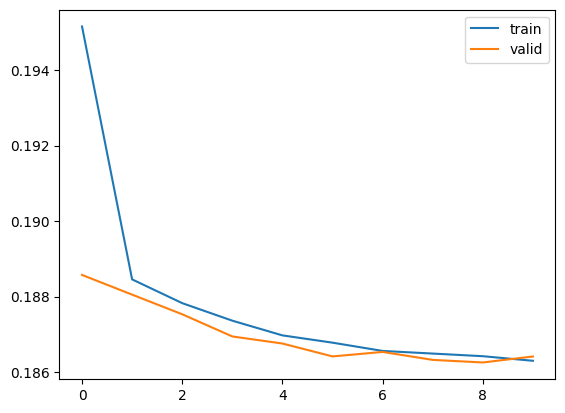

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [ ]:
#The trained encoder contains the reduced features from the code layers
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

In [ ]:
#Having a look at the output further:
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3
count,799999.000000,799999.000000,799999.000000,799999.000000
mean,0.004754,0.011039,0.059541,0.007792
std,0.998453,1.014434,0.978991,0.999855
min,-4.942445,-4.144800,-4.544682,-5.081950
25%,-0.668026,-0.677685,-0.645128,-0.666141
50%,0.004099,-0.052631,0.065961,0.008987
75%,0.677718,0.587460,0.724582,0.681881
max,4.793861,3.228823,3.970170,4.891587


In [ ]:
#normalize the generated features and create a dataframe with new columns labels to easily identify vs original features
norm_scaler4 = MinMaxScaler(feature_range = (0,1), clip=True).fit(gen_feat)
n_gen_feat = norm_scaler4.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = ["VAE1", "VAE2", "VAE3", "VAE4"]
n_gen_feat.columns = new_col_headers

In [ ]:
#add generated features dataframe to new features dataframe. With correct column/feature labels.

ori_label = training_multiattack_dataset.columns[2:34]
ori_label = ori_label.drop(['first_timestamp', 'last_timestamp'])

n_ori_feat = pd.DataFrame(n_X_train, columns = ori_label)

n_all_feat = pd.concat([n_ori_feat, n_gen_feat], axis = 1)
print(n_all_feat.shape)

(799999, 34)


In [ ]:
feat_label = pd.DataFrame(y_train, columns=["label"])
whole_all_feat = pd.concat([n_all_feat, feat_label], axis=1)
whole_all_feat['label'] = pd.to_numeric(whole_all_feat['label'])

In [ ]:
whole_all_feat.to_csv('./gdrive/MyDrive/backups_data/gen_feat_multiattack_dataset.csv', index=False)

In [ ]:
#Dimensionality Reduction 2 - PCA
pca = PCA(n_components = 2)

X_pca_train = pca.fit_transform(n_X_train)
X_pca_test = pca.transform(n_X_valid)

explained_variance = pca.explained_variance_ratio_

#Eigenvalues
print(pca.explained_variance_)
#Eigenvectors
print(pca.components_)
#percentage of variation explained by each eigen Vector
print(pca.explained_variance_ratio_)

classifier = LogisticRegression(random_state = 3)
classifier.fit(X_pca_train, y_train)

y_pred = classifier.predict(X_pca_test)

cm = confusion_matrix(y_valid, y_pred)

In [ ]:
#Having a look at the output further:
pca_featdf = pd.DataFrame(X_pca_train)
pca_featdf.describe()

,0,1
count,7.999990e+05,7.999990e+05
mean,-1.585232e-13,5.647371e-14
std,7.766455e-01,4.857658e-01
min,-8.679463e-01,-6.705067e-01
25%,-4.560604e-01,-4.545102e-01
50%,-2.489322e-01,1.295307e-01
75%,7.037097e-02,3.685223e-01
max,2.119876e+00,2.096871e+00


In [ ]:
#normalize the generated features and create a dataframe with new columns labels to easily identify vs original features
norm_scalerpca = MinMaxScaler(feature_range = (0,1), clip=True).fit(pca_featdf)
n_pca_feat = norm_scalerpca.transform(pca_featdf)
n_pca_feat = pd.DataFrame(n_pca_feat)
new_col_headers = ["PCA1", "PCA2"]
n_pca_feat.columns = new_col_headers

In [ ]:
#add generated features dataframe to new features dataframe. With correct column/feature labels.
y_labelss = whole_all_feat['label']
whole_all_feat = whole_all_feat.drop('label', axis=1)

whole_all_feat = pd.concat([whole_all_feat, n_pca_feat, y_labelss], axis = 1)
print(whole_all_feat.shape)

(799999, 37)


In [ ]:
whole_all_feat.to_csv('./gdrive/MyDrive/backups_data/gen_feat_multiattack_dataset.csv', index=False)

<ipython-input-15-5eadc7f20dbc>:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


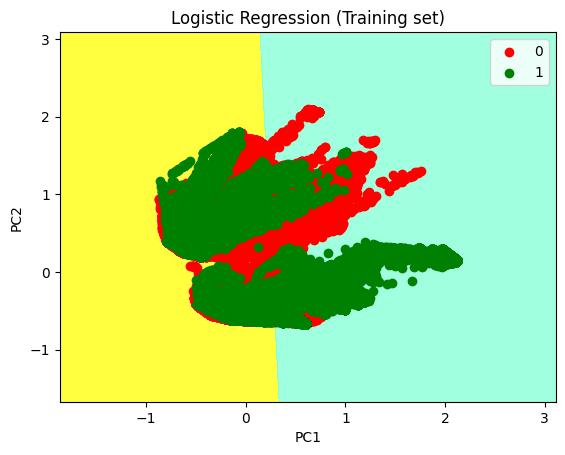

In [ ]:
X_set, y_set = X_pca_train, y_train
#X_set, y_set = n_X_valid, y_valid

X1, X2 = np.meshgrid(np.arange(start = X_set[:,0].min()-1,
                               stop = X_set[:,0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:,1].min()-1,
                               stop = X_set[:, 1].max() + 1, step = 0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
                                                  X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
              c = ListedColormap(('red', 'green', 'blue'))(i), label=j)

plt.title('Logistic Regression (Training set)')
#plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.show()

In [ ]:
#Dimensionality Reduction 3 - Multiple Denoising Autoencoder (MDAE)
from keras.layers import GaussianNoise
from keras.layers import Dropout

input_size = 30
code_size = 4
dropnoise = Dropout(.2, input_shape=(input_size,))
gausnoise = GaussianNoise(0.1, input_shape=(input_size,))

input_data = Input(shape=(input_size,))
noisy_data1 = dropnoise(input_data, training=True)
noisy_data2 = gausnoise(noisy_data1, training=True)
hidden_1 = Dense(15, activation='relu')(noisy_data2)
hidden_2 = Dense(8, activation='relu')(hidden_1)
code = Dense(code_size)(hidden_2)

mdsae_encoder = Model(
    [input_data], outputs = [code]
)

decoder_inputs = Input(shape = [code_size])
hidden_3 = Dense(8, activation='relu')(decoder_inputs)
hidden_4 = Dense(15, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

mdsae_decoder = Model(
    inputs = decoder_inputs, outputs = output_data
)

code = mdsae_encoder(input_data)
reconst = mdsae_decoder(code)
mdsae = Model(input_data, reconst)

In [ ]:
disable_eager_execution()
mdsae.compile(optimizer = 'adam', loss = tf.keras.losses.Huber())
history_mdsae = mdsae.fit(n_X_train, n_X_train, epochs = 10, validation_data = [n_X_valid, n_X_valid])

Train on 799999 samples, validate on 200000 samples
Epoch 1/10
799968/799999 [============================>.] - ETA: 0s - loss: 0.0048

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


799999/799999 [==============================] - 107s 133us/sample - loss: 0.0048 - val_loss: 0.0037
Epoch 2/10
799999/799999 [==============================] - 71s 89us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 3/10
799999/799999 [==============================] - 61s 76us/sample - loss: 0.0034 - val_loss: 0.0033
Epoch 4/10
799999/799999 [==============================] - 57s 72us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 5/10
799999/799999 [==============================] - 61s 76us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 6/10
799999/799999 [==============================] - 60s 74us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 7/10
799999/799999 [==============================] - 57s 71us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 8/10
799999/799999 [==============================] - 58s 72us/sample - loss: 0.0032 - val_loss: 0.0031
Epoch 9/10
799999/799999 [==============================] - 57s 71us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 10/10
799999/

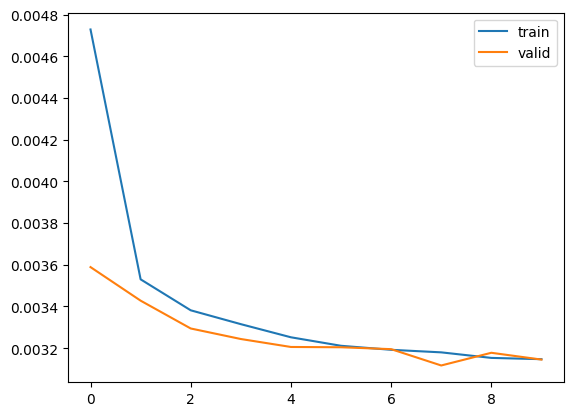

In [ ]:
plt.plot(history_mdsae.history['loss'], label='train')
plt.plot(history_mdsae.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [ ]:
#The trained encoder contains the reduced features from the code layers
encoded = mdsae_encoder
mdsae_gen_feat = encoded.predict(n_X_train)
print(mdsae_gen_feat.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(799999, 4)


In [ ]:
#Having a look at the output further:
mdsae_gen_featdf = pd.DataFrame(mdsae_gen_feat)
mdsae_gen_featdf.describe()

,0,1,2,3
count,799999.000000,799999.000000,799999.000000,799999.000000
mean,2.572535,-0.335373,-2.559501,1.901592
std,1.218941,1.980041,2.771897,1.642038
min,-4.752026,-15.111682,-13.959262,-3.396293
25%,1.997392,-1.222390,-3.050667,0.812913
50%,2.603971,-0.148681,-1.836420,1.511143
75%,3.433354,0.903365,-0.626185,2.731574
max,6.018416,4.630587,1.266634,9.488388


In [ ]:
#normalize the generated features and create a dataframe with new columns labels to easily identify vs original features
norm_scaler_ae = MinMaxScaler(feature_range = (0,1), clip=True).fit(mdsae_gen_feat)
n_mdsae_gen_feat = norm_scaler_ae.transform(mdsae_gen_feat)
n_mdsae_gen_feat = pd.DataFrame(n_mdsae_gen_feat)
new_col_headers = ["MDSAE1", "MDSAE2", "MDSAE3", "MDSAE4"]
n_mdsae_gen_feat.columns = new_col_headers

In [ ]:
#add generated features dataframe to new features dataframe. With correct column/feature labels.
y_labelss = whole_all_feat['label']
whole_all_feat = whole_all_feat.drop('label', axis=1)

whole_all_feat = pd.concat([whole_all_feat, n_mdsae_gen_feat, y_labelss], axis = 1)
print(whole_all_feat.shape)

(799999, 41)


In [ ]:
whole_all_feat.to_csv('./gdrive/MyDrive/backups_data/gen_feat_multiattack_dataset.csv', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


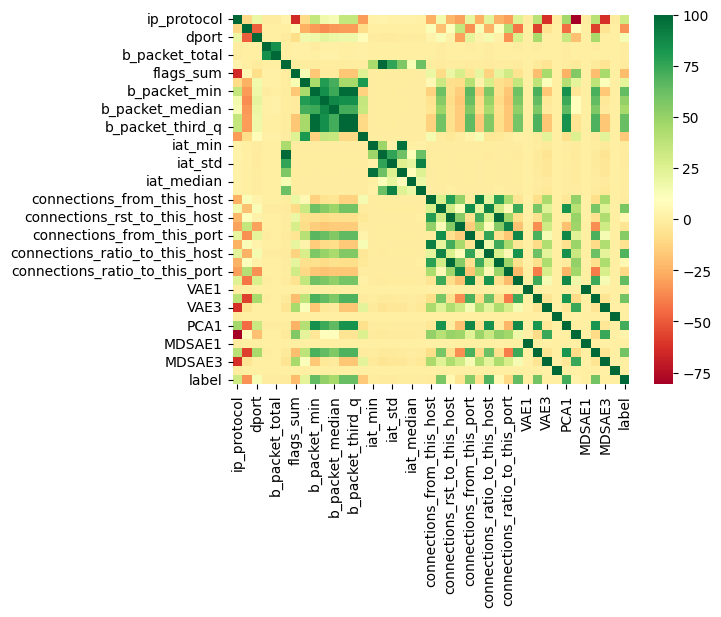

In [ ]:
#Correlation Matrix
corr_matrix = whole_all_feat.corr()
sn.heatmap(corr_matrix*100, annot=False, cmap="RdYlGn")
plt.show()

In [ ]:
#Selection 1: Variance Threshold Filter
n_all_feat = whole_all_feat.iloc[:,0:40]

feat_sel = VarianceThreshold()
feat_sel.fit_transform(n_all_feat)
red_feat = pd.DataFrame(feat_sel.transform(n_all_feat))
col_lst = n_all_feat.columns[feat_sel.get_support()]
print(col_lst)
print(len(col_lst))
red_feat.columns = col_lst
red_feat.shape

Index(['ip_protocol', 'sport', 'dport', 'in_packets', 'b_packet_total',
       'duration', 'flags_sum', 'b_packet_max', 'b_packet_min',
       'b_packet_mean', 'b_packet_median', 'b_packet_first_q',
       'b_packet_third_q', 'b_packet_std', 'iat_min', 'iat_max', 'iat_std',
       'iat_mean', 'iat_median', 'iat_var', 'connections_from_this_host',
       'connections_to_this_host', 'connections_rst_to_this_host',
       'connections_to_this_port', 'connections_from_this_port',
       'connections_ratio_from_this_host', 'connections_ratio_to_this_host',
       'connections_ratio_rst_to_this_host', 'connections_ratio_to_this_port',
       'connections_ratio_from_this_port', 'VAE1', 'VAE2', 'VAE3', 'VAE4',
       'PCA1', 'PCA2', 'MDSAE1', 'MDSAE2', 'MDSAE3', 'MDSAE4'],
      dtype='object')
40


(999999, 40)

In [ ]:
#Selection 2: Kbest with Chi2 Filter
y_train = pd.to_numeric(y_train)
kbest = SelectKBest(score_func = chi2, k=25)
kbest_out = kbest.fit_transform(red_feat, y_train)
kbest_out = red_feat.columns[kbest.get_support()]
print(kbest_out)

red_feat2 = pd.DataFrame(kbest.transform(red_feat))
red_feat2.columns = kbest_out
red_feat2.shape

Index(['ip_protocol', 'sport', 'dport', 'duration', 'flags_sum',
       'b_packet_max', 'b_packet_min', 'b_packet_mean', 'b_packet_median',
       'b_packet_first_q', 'b_packet_third_q', 'b_packet_std',
       'connections_from_this_host', 'connections_to_this_host',
       'connections_rst_to_this_host', 'connections_to_this_port',
       'connections_from_this_port', 'connections_ratio_from_this_host',
       'connections_ratio_to_this_host', 'connections_ratio_rst_to_this_host',
       'connections_ratio_to_this_port', 'connections_ratio_from_this_port',
       'VAE2', 'PCA1', 'MDSAE2'],
      dtype='object')


(999999, 25)

In [ ]:
#Selection 3: Kbest with MI Filter
kbest_mi = SelectKBest(score_func = mutual_info_classif, k=15)
kbest_mi_out = kbest_mi.fit_transform(red_feat2, y_train)
kbest_mi_out = red_feat2.columns[kbest_mi.get_support()]
print(kbest_mi_out)

X_train_final = pd.DataFrame(kbest_mi.transform(red_feat2))
X_train_final.columns = kbest_mi_out
X_train_final.shape

Index(['ip_protocol', 'sport', 'b_packet_max', 'b_packet_min', 'b_packet_mean',
       'b_packet_median', 'b_packet_first_q', 'b_packet_third_q',
       'connections_to_this_host', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'VAE2', 'PCA1', 'MDSAE2'],
      dtype='object')


(999999, 15)

In [ ]:
#checking - correlation function

def pairwise_corr(df, threshold=0.9):
  matrix = df.corr()
  mask = np.triu(np.ones_like(matrix, dtype=bool))
  reduced_matrix = matrix.mask(mask)
  col_to_drop = [col for col in reduced_matrix.columns if any (reduced_matrix[col] > threshold)]
  return col_to_drop

corr_columns = pairwise_corr(X_train_final, 0.884)
X_train_corr = X_train_final.drop(corr_columns, axis=1)
print(X_train_corr.shape)
print(corr_columns)

(999999, 10)
['b_packet_min', 'b_packet_mean', 'b_packet_first_q', 'connections_to_this_host', 'VAE2']


In [ ]:
print(X_train_corr.columns)
print(X_train_corr.shape)

Index(['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2'],
      dtype='object')
(999999, 10)


# 6) IDPS Model Development

In [ ]:
def formating (X):
  @keras.saving.register_keras_serializable(package="MyLayers")
  class Sampling(keras.layers.Layer):
    def call(self, input_data):
      mean, log_var = input_data
      return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

  X = X

  columns = ["ip_src_str", "ip_dst_str", "ip_protocol", "sport", "dport", "in_packets",
          "b_packet_total", "first_timestamp", "last_timestamp", "duration", "flags_sum",
          "urg_nr_count", "ack_nr_count", "rst_nr_count", "fin_nr_count", "psh_nr_count", "syn_nr_count",
          "b_packet_max", "b_packet_min", "b_packet_mean", "b_packet_median", "b_packet_first_q",
          "b_packet_third_q", "b_packet_std", "iat_min", "iat_max", "iat_first_q",
          "iat_third_q", "iat_std", "iat_mean", "iat_median", "iat_var",
           "connections_from_this_host", "connections_to_this_host", "connections_rst_to_this_host",
           "connections_rst_from_this_host", "connections_to_this_port", "connections_from_this_port",
          "connections_ratio_from_this_host", "connections_ratio_to_this_host", "connections_ratio_rst_to_this_host",
          "connections_ratio_rst_from_this_host", "connections_ratio_to_this_port", "connections_ratio_from_this_port",
          "label", "attack_label", "attack_file"]

  X = X.reindex(columns=columns)

  to_drop = ['connections_ratio_rst_from_this_host', #0 values, meaningless
           'connections_rst_from_this_host', #0 values, meaningless
           'iat_third_q', #0 values, meaningless
           'iat_first_q', #0 values, meaningless
           "urg_nr_count", #covered by flags_sum
           "ack_nr_count", #covered by flags_sum
           "rst_nr_count", #covered by flags_sum
           "fin_nr_count", #covered by flags_sum
           "psh_nr_count", #covered by flags_sum
           "syn_nr_count", #covered by flags_sum
           "attack_label",
           "attack_file",
           "Unnamed: 0.1",
           "Unnamed: 0"
        ]

  X.drop(columns=to_drop, axis=1, inplace=True, errors='ignore')

  ori_label = X.columns[2:34]
  ori_label = ori_label.drop(['first_timestamp', 'last_timestamp'], errors='ignore')

  array = X.values
  X_train = array[:, 2:34]
  X_train = np.delete(X_train, [5,6], axis=1)#ip address and timestamp data excluded
  y_train = array[:, 34]
  y_train = y_train.astype('int32')

  # joblib.dump(norm_scaler, './gdrive/MyDrive/clean/scaler.save')
  norm_scaler = joblib.load('./gdrive/MyDrive/clean/scaler.save')
  n_X_train = norm_scaler.transform(X_train)

  # var_encoder.save('./gdrive/MyDrive/clean/var_encoder_v1.h5')
  var_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/var_encoder_v1.h5', compile=False)
  encoded = var_encoder
  gen_feat = encoded.predict(n_X_train)
  gen_featdf = pd.DataFrame(gen_feat)
  # joblib.dump(norm_scaler4, './gdrive/MyDrive/clean/vae_scaler.save')
  norm_scaler4 = joblib.load('./gdrive/MyDrive/clean/vae_scaler.save')
  n_gen_feat = norm_scaler4.transform(gen_feat)
  n_gen_feat = pd.DataFrame(n_gen_feat)
  new_col_headers = ["VAE1", "VAE2", "VAE3", "VAE4"]
  n_gen_feat.columns = new_col_headers

  # joblib.dump(pca, './gdrive/MyDrive/clean/pca.sav')
  pca = joblib.load('./gdrive/MyDrive/clean/pca.sav')
  X_pca_train = pca.fit_transform(n_X_train)
  pca_featdf = pd.DataFrame(X_pca_train)
  # joblib.dump(norm_scalerpca, './gdrive/MyDrive/clean/pca_scaler.save')
  norm_scalerpca = joblib.load('./gdrive/MyDrive/clean/pca_scaler.save')
  n_pca_feat = norm_scalerpca.transform(pca_featdf)
  n_pca_feat = pd.DataFrame(n_pca_feat)
  new_col_headers = ["PCA1", "PCA2"]
  n_pca_feat.columns = new_col_headers

  # mdsae_encoder.save('./gdrive/MyDrive/clean/mdsae_encoder.h5')
  mdsae_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/mdsae_encoder.h5', compile=False)
  mdsae_encoded = mdsae_encoder
  mdsae_gen_feat = mdsae_encoded.predict(n_X_train)
  mdsae_gen_featdf = pd.DataFrame(mdsae_gen_feat)
  # joblib.dump(norm_scaler_ae, './gdrive/MyDrive/clean/mdsae_scaler.save')
  norm_scaler_ae = joblib.load('./gdrive/MyDrive/clean/mdsae_scaler.save')
  n_mdsae_gen_feat = norm_scaler_ae.transform(gen_feat)
  n_mdsae_gen_feat = pd.DataFrame(n_mdsae_gen_feat)
  new_col_headers = ["MDSAE1", "MDSAE2", "MDSAE3", "MDSAE4"]
  n_mdsae_gen_feat.columns = new_col_headers

  n_ori_feat = pd.DataFrame(n_X_train, columns = ori_label)
  feat_label = pd.DataFrame(y_train, columns=["label"])
  whole_all_feat = pd.concat([n_ori_feat, n_gen_feat, n_pca_feat, n_mdsae_gen_feat, feat_label], axis=1)
  whole_all_feat['label'] = pd.to_numeric(whole_all_feat['label'])

  return whole_all_feat

In [ ]:
class data_cls:
  def __init__(self, path, train_test=None, cols=0, customized=False):
    top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

    original = ['ip_protocol', 'sport', 'dport', 'in_packets', 'b_packet_total',
       'duration', 'flags_sum', 'b_packet_max', 'b_packet_min',
       'b_packet_mean', 'b_packet_median', 'b_packet_first_q',
       'b_packet_third_q', 'b_packet_std', 'iat_min', 'iat_max', 'iat_std',
       'iat_mean', 'iat_median', 'iat_var', 'connections_from_this_host',
       'connections_to_this_host', 'connections_rst_to_this_host',
       'connections_to_this_port', 'connections_from_this_port',
       'connections_ratio_from_this_host', 'connections_ratio_to_this_host',
       'connections_ratio_rst_to_this_host', 'connections_ratio_to_this_port',
       'connections_ratio_from_this_port', 'label']

    ori_reduced = ['ip_protocol', 'sport', 'dport', 'in_packets', 'b_packet_total',
       'duration', 'flags_sum', 'b_packet_max', 'b_packet_min',
       'b_packet_mean', 'b_packet_median', 'b_packet_first_q',
       'b_packet_third_q', 'b_packet_std', 'iat_min', 'iat_max', 'iat_std',
       'iat_mean', 'iat_median', 'iat_var', 'connections_from_this_host',
       'connections_to_this_host', 'connections_rst_to_this_host',
       'connections_to_this_port', 'connections_from_this_port',
       'connections_ratio_from_this_host', 'connections_ratio_to_this_host',
       'connections_ratio_rst_to_this_host', 'connections_ratio_to_this_port',
       'connections_ratio_from_this_port', 'VAE1', 'VAE2', 'VAE3', 'VAE4',
       'PCA1', 'PCA2', 'MDSAE1', 'MDSAE2', 'MDSAE3', 'MDSAE4', 'label']

    VAE = ['VAE1', 'VAE2', 'VAE3', 'VAE4', 'label']
    PCA = ['PCA1', 'PCA2', 'label']
    MDSAE = ['MDSAE1', 'MDSAE2', 'MDSAE3', 'MDSAE4', 'label']

    self.cols = cols
    self.choice = [top10, original, ori_reduced, VAE, PCA, MDSAE]
    self.index = 0
    self.headers = None
    self.loaded = False
    self.train_test = train_test
    self.formatted_path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'
    self.test_path = './gdrive/MyDrive/test_gen_feat_multiattack_dataset.csv'

    if (not path):
      print("Path: not path name provided", flush=True)
      sys.exit(0)

    formated = False

    if os.path.exists(path) and train_test == 'test' and customized:
      self.test_path = path
      formated = True
    elif os.path.exists(self.formatted_path) and train_test=='train':
      formated = True
    elif os.path.exists(self.test_path) and train_test=='test':
      formated = True
    elif os.path.exists(self.test_path) and os.path.exists(self.formatted_path) and (train_test == 'full'):
      formated = True

    if not formated:
      self.df = pd.read_csv(path)
      self.df = self._formating(self.df)
      self.loaded = True

      if train_test == "train":
        self.df.to_csv(self.formatted_path, index=False)
      elif train_test == 'test':
        self.df.to_csv(self.test_path, index=False)
      else:
        columns = self.df.columns

        array = self.df.values
        X_train = array[:, 0:40]
        y_train = array[:, 40]
        y_train = y_train.astype('int32')

        #Split into train and validation set
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

        train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
        train.columns = columns
        valid = pd.concat([pd.DataFrame(X_valid), pd.DataFrame(y_valid)], axis=1)
        valid.columns = columns

        self.df = train
        valid.to_csv(self.test_path, index=False)
        self.df.to_csv(self.formatted_path, index=False)


  def get_batch(self, batch_size = 1000):
    if self.loaded is False:
      self._load_df(self.choice[self.cols])


    indexes = list(range(self.index, self.index+batch_size))
    if max(indexes) > self.data_shape[0]-1:
      dif = max(indexes) - self.data_shape[0]
      indexes[len(indexes) - dif-1:len(indexes)] = list(range(dif+1))
      self.index = batch_size-dif
      batch = self.df.iloc[indexes]
    else:
      batch = self.df.iloc[indexes]
      self.index += batch_size

    labels = batch['label'].values

    del(batch['label'])

    return batch, labels

  def get_shape(self):
    if self.loaded is False:
      self._load_df(self.choice[self.cols])

    self.data_shape = self.df.shape

    return self.data_shape

  def _load_df(self, cols):
    if self.train_test == 'train' or self.train_test == 'full':
      self.df = pd.read_csv(self.formatted_path, usecols=cols)
    else:
      self.df = pd.read_csv(self.test_path, usecols=cols)
    self.loaded=True

  def _formating (self, X):
    @keras.saving.register_keras_serializable(package="MyLayers")
    class Sampling(keras.layers.Layer):
      def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

    X = X

    to_drop = ['connections_ratio_rst_from_this_host', #0 values, meaningless
            'connections_rst_from_this_host', #0 values, meaningless
            'iat_third_q', #0 values, meaningless
            'iat_first_q', #0 values, meaningless
            "urg_nr_count", #covered by flags_sum
            "ack_nr_count", #covered by flags_sum
            "rst_nr_count", #covered by flags_sum
            "fin_nr_count", #covered by flags_sum
            "psh_nr_count", #covered by flags_sum
            "syn_nr_count", #covered by flags_sum
            "attack_label",
            "attack_file",
            "Unnamed: 0.1",
            "Unnamed: 0"
          ]

    X.drop(columns=to_drop, axis=1, inplace=True, errors='ignore')

    ori_label = X.columns[2:34]
    ori_label = ori_label.drop(['first_timestamp', 'last_timestamp'], errors='ignore')

    array = X.values
    X_train = array[:, 2:34]
    X_train = np.delete(X_train, [5,6], axis=1)#ip address and timestamp data excluded
    y_train = array[:, 34]
    y_train = y_train.astype('int32')

    # joblib.dump(norm_scaler, './gdrive/MyDrive/clean/scaler.save')
    norm_scaler = joblib.load('./gdrive/MyDrive/clean/scaler.save')
    n_X_train = norm_scaler.transform(X_train)

    # var_encoder.save('./gdrive/MyDrive/clean/var_encoder_v1.h5')
    var_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/var_encoder_v1.h5', compile=False)
    encoded = var_encoder
    gen_feat = encoded.predict(n_X_train)
    gen_featdf = pd.DataFrame(gen_feat)
    # joblib.dump(norm_scaler4, './gdrive/MyDrive/clean/vae_scaler.save')
    norm_scaler4 = joblib.load('./gdrive/MyDrive/clean/vae_scaler.save')
    n_gen_feat = norm_scaler4.transform(gen_feat)
    n_gen_feat = pd.DataFrame(n_gen_feat)
    new_col_headers = ["VAE1", "VAE2", "VAE3", "VAE4"]
    n_gen_feat.columns = new_col_headers

    # joblib.dump(pca, './gdrive/MyDrive/clean/pca.sav')
    pca = joblib.load('./gdrive/MyDrive/clean/pca.sav')
    X_pca_train = pca.fit_transform(n_X_train)
    pca_featdf = pd.DataFrame(X_pca_train)
    # joblib.dump(norm_scalerpca, './gdrive/MyDrive/clean/pca_scaler.save')
    norm_scalerpca = joblib.load('./gdrive/MyDrive/clean/pca_scaler.save')
    n_pca_feat = norm_scalerpca.transform(pca_featdf)
    n_pca_feat = pd.DataFrame(n_pca_feat)
    new_col_headers = ["PCA1", "PCA2"]
    n_pca_feat.columns = new_col_headers

    # mdsae_encoder.save('./gdrive/MyDrive/clean/mdsae_encoder.h5')
    mdsae_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/mdsae_encoder.h5', compile=False)
    mdsae_encoded = mdsae_encoder
    mdsae_gen_feat = mdsae_encoded.predict(n_X_train)
    mdsae_gen_featdf = pd.DataFrame(mdsae_gen_feat)
    # joblib.dump(norm_scaler_ae, './gdrive/MyDrive/clean/mdsae_scaler.save')
    norm_scaler_ae = joblib.load('./gdrive/MyDrive/clean/mdsae_scaler.save')
    n_mdsae_gen_feat = norm_scaler_ae.transform(gen_feat)
    n_mdsae_gen_feat = pd.DataFrame(n_mdsae_gen_feat)
    new_col_headers = ["MDSAE1", "MDSAE2", "MDSAE3", "MDSAE4"]
    n_mdsae_gen_feat.columns = new_col_headers

    n_ori_feat = pd.DataFrame(n_X_train, columns = ori_label)
    feat_label = pd.DataFrame(y_train, columns=["label"])
    whole_all_feat = pd.concat([n_ori_feat, n_gen_feat, n_pca_feat, n_mdsae_gen_feat, feat_label], axis=1)
    whole_all_feat['label'] = pd.to_numeric(whole_all_feat['label'])

    return whole_all_feat

class RLenv(data_cls):
  def __init__(self, path, train_test, batch_size=1000, customized=False):
    data_cls.__init__(self, path, train_test, customized=customized)
    self.batch_size = batch_size
    self.state_shape = data_cls.get_shape(self)

  def _update_state(self):
    self.states, self.labels = data_cls.get_batch(self, self.batch_size)

  '''
  Returns:
    + Observation of the environment
  '''

  def reset(self):
    self.state_numb = 0
    self.states, self.labels = data_cls.get_batch(self, self.batch_size)
    self.total_reward = 0
    self.steps_in_episode = 0
    return self.states.values

  '''
  Returns:
    State: Next state for the game
    Reward: Actual reward
    done: If the game ends (no end in this case)
  '''

  def act(self, actions):
    self.reward = np.zeros(self.batch_size)
    for indx, a in enumerate(actions):
      if a == self.labels[indx]:
        self.reward[indx] = 1

    #Get new state and new true values
    self._update_state()

    #Done always false in this continuous task
    self.done = False

    return self.states, self.reward, self.done

def main(num_episodes=200, decay_rate=0.99, gamma=0.001, verbose=1, printing=0, train_test = "train", vhs_path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'):
  #valid action = '0' suppose no attack, '1' suppose attack
  valid_actions = [0,1]
  num_actions = len(valid_actions)
  epsilon = .1
  num_episodes = num_episodes #CAN BE FINE TUNED MANUALLY [100, 150, 200, 250, 300]
  iterations_episodes = 100
  decay_rate = decay_rate #TRY TO FINE TUNED MANUALLY [0.999, 0.99, 0.9, 0.85]
  gamma = gamma # CAN BE FINE TUNED MANUALLY [0.001, 0.1, 0.9]
  hidden_size = 100
  batch_size = 500

  #Initialization of the environment
  env = RLenv(vhs_path, train_test, batch_size)

  #Network architecture
  model = Sequential()
  model.add(Dense(hidden_size, input_shape=(env.state_shape[1]-1,),
                  batch_size=batch_size, activation='relu'))
  model.add(Dense(hidden_size, activation='relu'))
  model.add(Dense(num_actions))
  model.compile(SGD(lr=.2), 'mse')

  reward_chain = []
  loss_chain = []

  for epoch in range(num_episodes):
    loss = 0.
    total_reward_by_episode = 0
    #Reset environment, actualize the data branch
    states = env.reset()

    done = False
    #Get control of the actions taken
    ones = 0
    zeros = 0

    exploration = 1
    #Iteration in one episode
    q = np.zeros([batch_size, num_actions])
    for i_iteration in range(iterations_episodes):
      #get next action
      if exploration > 0.001:
        exploration = epsilon*decay_rate**(epoch*i_iteration)

      if np.random.rand() <= exploration:
        actions = np.random.randint(0, num_actions, batch_size)

      else:
        q=model.predict(states)
        actions = np.argmax(q, axis=1)

      #apply actions, get rewards and new state
      next_states, reward, done = env.act(actions)
      #If the epoch*batch_size_iterations_episode is larger than the df
      if next_states.shape[0] != batch_size:
        break

      q_prime = model.predict(next_states)
      indx = np.argmax(q_prime, axis=1)
      sx = np.arange(len(indx))
      #Update q values
      targets = reward + gamma * q[sx, indx]
      q[sx, actions] = targets

      #Train network, update loss
      loss += model.train_on_batch(states, q)

      #Update the state
      states = next_states

      ones += int(sum(actions))
      zeros += batch_size - int(sum(actions))
      total_reward_by_episode += int(sum(reward))

    if next_states.shape[0] != batch_size:
      break #finished df

    reward_chain.append(total_reward_by_episode)
    loss_chain.append(loss)

    if verbose==1:
      print("\rEpoch {:03d}/{:03d} | Loss {:4.4f} | Tot reward x episode {:03d}| Ones/Zeros: {}/{} ".format(epoch,
            num_episodes ,loss, total_reward_by_episode,ones,zeros))

  #Save trained model weights and architecture, used in test
  model.save_weights("./gdrive/MyDrive/DQL_model_tune/models/model.h5", overwrite=True)
  with open("./gdrive/MyDrive/DQL_model_tune/models/model.json", 'w') as outfile:
    json.dump(model.to_json(), outfile)

  if printing==1:
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.plot(np.arange(len(loss_chain)), loss_chain, color='blue')
    ax1.set_ylabel('Loss', color='blue')

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(reward_chain)), reward_chain, color = 'orange')
    ax2.set_ylabel('Total reward', color='orange')

    ax1.set_xlabel("n Episode")
    if verbose == 1:
      plt.title('Training Progress')
    else:
      plt.title('Training Progress (Gamma: ' + save_label + ")")
    plt.tight_layout()
    if verbose == 1:
      plt.savefig('./gdrive/MyDrive/DQL_model_tune/results/train_simple.eps', format='eps', dpi=1000)
    else:
      plt.savefig('./gdrive/MyDrive/DQL_model_tune/gamma_tune' + save_file_time + '.eps', format='eps', dpi=1000)

    plt.show()


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting  `normalize=True`
  """

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  # print(cm)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2f}%".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns_plot = sn.heatmap(cm, annot=labels, fmt='', cmap=cmap)
  sns_plot
  plt.title(title)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classes))+0.5
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

def evaluate(num_episodes=200, decay_rate=0.99, gamma=0.001, verbose=0, printing=0, train_test = "train", path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv', model_name = "model", customized=False):
  if train_test == 'train':
    main(num_episodes=num_episodes, decay_rate=decay_rate, gamma=gamma, verbose=verbose, printing=printing, train_test=train_test, vhs_path=path)

  start = time()

  test_path = path

  with open("./gdrive/MyDrive/DQL_model_tune/models/" + model_name + ".json", "r") as jfile:
    model = model_from_json(json.load(jfile))
  model.load_weights("./gdrive/MyDrive/DQL_model_tune/models/" + model_name + ".h5")
  model.compile("sgd", "mse")

  batch_size = 500
  #Define environment
  env = RLenv(test_path, "test", batch_size, customized=customized)

  true_ones = 0
  true_zeros = 0
  false_ones = 0 #false negative
  false_zeros = 0 #false positive
  total_reward = 0
  all_labels = np.array([])
  all_actions = np.array([])
  epochs = int(env.state_shape[0]/env.batch_size)
  for e in range(epochs):
    states, labels = env.get_batch(batch_size = env.batch_size)
    q = model.predict(states)
    actions = np.argmax(q, axis=1)

    all_labels = np.append(all_labels, labels)
    all_actions = np.append(all_actions, actions)

    reward = np.zeros(env.batch_size)
    for indx, a in enumerate(actions):
      if a == labels[indx]:
        reward[indx] = 1
        if a == 0:
          true_zeros += 1
        else:
          true_ones += 1
      else:
        if a==0:
          false_zeros += 1
        else:
          false_ones += 1

    total_reward += int(sum(reward))
    if verbose == 1:
      print("\rEpoch {}/{} | Ones/Zeros: {}/{}  Tot Rew -- > {}".format(e,epochs,true_ones,true_zeros,total_reward), end="")

  if verbose == 1:
    print('\r\nTotal reward: {} | Number of samples: {} | Acuracy = {}%'.format(total_reward,
          int(epochs*env.batch_size),float(100*total_reward/(epochs*env.batch_size))))

  end = time()
  duration = end - start

  if printing == 1 and verbose == 1:
    ind = np.arange(1, 5)
    fig, ax = plt.subplots()

    t_o, f_o, t_z, f_z = plt.bar(ind, (true_ones, false_ones, true_zeros, false_zeros))

    t_o.set_facecolor('g')
    f_o.set_facecolor('r')
    t_z.set_facecolor('g')
    f_z.set_facecolor('r')

    ax.set_xticks(ind)
    ax.set_xticklabels(['True ones', 'False ones', 'True zeros', 'False zeros'])

    ax.set_title('Test set')
    plt.tight_layout()
    plt.savefig('./gdrive/MyDrive/DQL_model_tune/results/test_simple_nat.eps', format='eps', dpi=1000)

  cv_results = {
      'episode': num_episodes,
      'decay': decay_rate,
      'gamma': gamma,
      'score_time': duration,
      'accuracy': accuracy_score(all_labels, all_actions),
      'precision': precision_score(all_labels, all_actions),
      'recall': recall_score(all_labels, all_actions),
      'f1': f1_score(all_labels, all_actions)
  }

  #Aggregate precision
  if verbose == 1:
    print(f"Episode\t\tDecay\t\tGamma\t\tTime\t\tAccuracy\tPrecision\tRecall\t\tF1")
  for values in cv_results.values():
    print(f"{round(values, 5)}", end="\t\t")
  print()


  if printing==1 and verbose == 1:
    cnf_matrix = confusion_matrix(all_labels, all_actions)
    np.set_printoptions(precision=2)
    plt.figure()
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Attack'], normalize=False,
                          title='Normalized confusion matrix')
    plt.savefig('./gdrive/MyDrive/DQL_model_tune/results/confusion_matrix_simple.eps', format='eps', dpi=1000)

  return cv_results


# 7) Ensemble

In [ ]:
#Modeling
#Preprocessing - 80:20 from sample
formatted_path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'
test_path = './gdrive/MyDrive/test_gen_feat_multiattack_dataset.csv'
top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

X_train = pd.read_csv(formatted_path, usecols=top10)
array = X_train.values
X = array[:, 0:10]
Y = array[:, 10]

#Selecting Algorithms
#IDPS Target models - SGD, RF, DRL
models = []
models.append(('SGD', SGDClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('LR', LogisticRegression(solver='liblinear', random_state=42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ET', ExtraTreesClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('LSVC', LinearSVC(random_state=42)))

#evaluate each model in turn
results = []
names = []
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
           }
print(f"Model\t\tFit time\tScore time\tAccuracy\tPrecision\tRecall\t\tF1")
for name, model in models:
  kfold = KFold(n_splits = 10, random_state = 3, shuffle=True)
  cv_results = cross_validate(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(name, end="\t\t")
  for key in cv_results.keys():
    print(f"{round(cv_results[key].mean(), 3)}", end="\t\t")
  print()


with open("./gdrive/MyDrive/result.csv", "wb") as f:
  pickle.dump((results), f)

Model		Fit time	Score time	Accuracy	Precision	Recall		F1
SGD		0.949		0.156		0.913		0.905		0.751		0.821		
RF		179.585		1.219		0.99		0.991		0.973		0.982		
LR		3.69		0.159		0.913		0.908		0.749		0.821		
LDA		0.954		0.188		0.912		0.907		0.747		0.82		
QDA		0.327		0.184		0.904		0.839		0.791		0.814		
KNN		1.903		23.076		0.979		0.973		0.949		0.961		
ET		61.123		1.774		0.99		0.99		0.971		0.98		
NB		0.173		0.124		0.906		0.87		0.76		0.812		
LSVC		18.337		0.163		0.914		0.91		0.751		0.823		


'\nNotes on results:\nSGD -\nRF -\nLR -\nLDA -\nQDA -\nKNN -\nET -\nNB -\nLSVC -\n'

In [ ]:
models = []
models.append(('SGD', SGDClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('LR', LogisticRegression(solver='liblinear', random_state=42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ET', ExtraTreesClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('LSVC', LinearSVC(random_state=42)))

with open("./gdrive/MyDrive/result.csv", "rb") as f:
  retrieved_results = pickle.load(f)

# print(retrieved_results)

print(f"Model\t\tFit time\t\tScore time\t\tAccuracy\t\tPrecision\t\tRecall\t\t\tF1")


for name, cv_results in zip(models, retrieved_results):
  print(name[0], end="\t\t")
  for key in cv_results.keys():
    print(f"{round(cv_results[key].mean(), 5): .5f}", end="\t\t")
  print()

print("""
Notes on results:
0) Choice critera
     a) Choose fast model [SGD, RF, LR, LDA, QDA, ET, NB, LSVC]
     b) High precision model. [RF, ET, LSVC, SGD, LR] - top 5

1) Tune Further
     a) RF - Fit slow. Performance is good.
     b) ET - Fit slow. Performance is good.
     c) LSVC - Fit quickly. Performance worse than RF.
     d) SGD - Fit quickly. Performance is worse than RF.
     e) LR - Fit quickly. Performance worse than RF.

2) Abandon
     a) LDA - Fit quickly. Performance worse than RF.
     b) QDA - Fit quickly. Performance worse than RF.
     c) KNN - Fit super slow. Performance is good.
     d) NB - Fit quickly. Performance is worse than RF
""")

Model		Fit time		Score time		Accuracy		Precision		Recall			F1
SGD		 0.94889		 0.15556		 0.91261		 0.90536		 0.75050		 0.82068		
RF		 179.58478		 1.21855		 0.99029		 0.99054		 0.97286		 0.98162		
LR		 3.68972		 0.15896		 0.91273		 0.90765		 0.74866		 0.82052		
LDA		 0.95415		 0.18806		 0.91241		 0.90747		 0.74749		 0.81974		
QDA		 0.32715		 0.18446		 0.90379		 0.83866		 0.79110		 0.81419		
KNN		 1.90327		 23.07561		 0.97922		 0.97281		 0.94853		 0.96051		
ET		 61.12310		 1.77396		 0.98967		 0.99032		 0.97071		 0.98042		
NB		 0.17278		 0.12427		 0.90600		 0.87049		 0.76032		 0.81168		
LSVC		 18.33746		 0.16278		 0.91392		 0.91028		 0.75095		 0.82297		

Notes on results:
0) Choice critera
     a) Choose fast model [SGD, RF, LR, LDA, QDA, ET, NB, LSVC]
     b) High precision model. [RF, ET, LSVC, SGD, LR] - top 5

1) Tune Further
     a) RF - Fit slow. Performance is good. 
     b) ET - Fit slow. Performance is good.
     c) LSVC - Fit quickly. Performance worse than RF. 
     d) SGD - Fit

In [ ]:
#SVEM Model
classifiers = [
    models.append(('RF', RandomForestClassifier(random_state=42))),
    models.append(('ET', ExtraTreesClassifier(random_state=42))),
    models.append(('LSVC', LinearSVC(random_state=42))),
    models.append(('SGD', SGDClassifier(random_state=42))),
    models.append(('LR', LogisticRegression(solver='liblinear', random_state=42)))
]

voting_clf = VotingClassifier(estimators = classifiers, voting='soft') #hard for hard voting
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict_proba(X_valid)
print(accuracy_score(y_valid, y_pred.argmax(axis=1))) #no argmax for hard voting


# 8) Hypermarameter Tuning

In [ ]:
#Environment Setup - 80:20 from sample
formatted_path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'
valid_path = './gdrive/MyDrive/test_gen_feat_multiattack_dataset.csv'
top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

X_train = pd.read_csv(formatted_path, usecols=top10)
array = X_train.values
X = array[:, 0:10]
Y = array[:, 10]

Random Forest

In [ ]:
param_grid = [
    {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1,2,4],
        'min_samples_split': [2,5,10],
        'n_estimators': [200, 400, 600, 800]
    }
]

rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_model, param_grid, random_state=42, cv=5, verbose=2)
rf_search.fit(X, Y)

print(rf_search.best_params_)
print(rf_search.best_estimator_)
print(rf_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=30.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=32.6min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=31.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=32.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=31.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=47.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=48.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=41.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=41.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=41.1min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 6.3min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 6.1min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 6.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 6.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 6.2min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=29.9min
[CV] END bootstrap=False, max_dept

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=40.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=45.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=42.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=42.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=43.5min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=11.5min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=10.9min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=11.6min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=11.7min
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=11.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=17.5min
[CV] END bootstrap=True, max_depth=20, max

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=28.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=27.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=28.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=28.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=27.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=33.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=33.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=33.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=32.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=32.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_leaf=2, n_estimators=800, random_state=42)
0.9903399883202397


In [ ]:
rf_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [ ]:
rf_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_leaf=2, n_estimators=800, random_state=42)

In [ ]:
rf_search.best_score_

0.9903399883202397

Extra Trees

In [ ]:
param_grid = [
    {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1,2,4],
        'min_samples_split': [2,5,10],
        'n_estimators': [50, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
    }
]

et_model = ExtraTreesClassifier(random_state=42)
et_search = ExtraTreesClassifier(et_model, param_grid, random_state=42, cv=5, verbose=2)
et_search.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 8.7min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=10.0min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=10.1min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 9.6min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 9.4min
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

In [ ]:
et_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [ ]:
et_search.best_estimator_

ExtraTreesClassifier(max_depth=70, min_samples_split=10, n_estimators=800,
                     random_state=42)

In [ ]:
et_search.best_score_

0.9890524866717918

Linear SVC

In [ ]:
param_grid3 = [
    {'penalty': ['l1', 'l2'], 'loss': ['squared_hinge', 'hinge'], 'C':[0.1,0.3,0.5,0.8,1.0,1.2,1.5,2.0]}
]

lsvc_model = LinearSVC(random_state=42)

lsvc_search = RandomizedSearchCV(lsvc_model, param_grid3, random_state=42, cv=5, verbose=2)
lsvc_search.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..............C=2.0, loss=squared_hinge, penalty=l2; total time=  39.2s
[CV] END ..............C=2.0, loss=squared_hinge, penalty=l2; total time=  45.7s
[CV] END ..............C=2.0, loss=squared_hinge, penalty=l2; total time=  44.8s
[CV] END ..............C=2.0, loss=squared_hinge, penalty=l2; total time=  44.0s
[CV] END ..............C=2.0, loss=squared_hinge, penalty=l2; total time=  44.8s
[CV] END ......................C=0.8, loss=hinge, penalty=l2; total time=   8.6s
[CV] END ......................C=0.8, loss=hinge, penalty=l2; total time=   8.5s
[CV] END ......................C=0.8, loss=hinge, penalty=l2; total time=  10.4s
[CV] END ......................C=0.8, loss=hinge, penalty=l2; total time=   6.9s
[CV] END ......................C=0.8, loss=hinge, penalty=l2; total time=   8.7s
[CV] END ..............C=1.5, loss=squared_hinge, penalty=l1; total time=   0.3s
[CV] END ..............C=1.5, loss=squared_hinge

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=42),
                   param_distributions=[{'C': [0.1, 0.3, 0.5, 0.8, 1.0, 1.2,
                                               1.5, 2.0],
                                         'loss': ['squared_hinge', 'hinge'],
                                         'penalty': ['l1', 'l2']}],
                   random_state=42, verbose=2)

In [ ]:
lsvc_search.best_params_

{'penalty': 'l2', 'loss': 'hinge', 'C': 0.8}

In [ ]:
lsvc_search.best_estimator_

LinearSVC(C=0.8, loss='hinge', random_state=42)

In [ ]:
lsvc_search.best_score_

0.914366143194645

Stochastic Gradient Descent

In [ ]:
param_grid3 = [
    {'penalty': ['l1', 'l2', 'elasticnet'],
     'loss': ['modified_huber', 'hinge', 'log_loss'],
     'max_iter':[1,2,3,4,5]}
]

sgd_model = SGDClassifier(random_state=42)

sgd_search = RandomizedSearchCV(sgd_model, param_grid3, random_state=42, cv=5, verbose=2)
sgd_search.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..............loss=log_loss, max_iter=4, penalty=l1; total time=   1.2s
[CV] END ..............loss=log_loss, max_iter=4, penalty=l1; total time=   1.2s
[CV] END ..............loss=log_loss, max_iter=4, penalty=l1; total time=   0.9s
[CV] END ..............loss=log_loss, max_iter=4, penalty=l1; total time=   0.8s
[CV] END ..............loss=log_loss, max_iter=4, penalty=l1; total time=   0.8s
[CV] END .................loss=hinge, max_iter=4, penalty=l2; total time=   0.6s
[CV] END .................loss=hinge, max_iter=4, penalty=l2; total time=   0.6s
[CV] END .................loss=hinge, max_iter=4, penalty=l2; total time=   0.6s
[CV] END .................loss=hinge, max_iter=4, penalty=l2; total time=   0.6s
[CV] END .................loss=hinge, max_iter=4, penalty=l2; total time=   0.6s
[CV] END .........loss=hinge, max_iter=4, penalty=elasticnet; total time=   0.7s
[CV] END .........loss=hinge, max_iter=4, penalt

RandomizedSearchCV(cv=5, estimator=SGDClassifier(random_state=42),
                   param_distributions=[{'loss': ['modified_huber', 'hinge',
                                                  'log_loss'],
                                         'max_iter': [1, 2, 3, 4, 5],
                                         'penalty': ['l1', 'l2',
                                                     'elasticnet']}],
                   random_state=42, verbose=2)

In [ ]:
sgd_search.best_params_

{'penalty': 'l1', 'max_iter': 2, 'loss': 'modified_huber'}

In [ ]:
sgd_search.best_estimator_

SGDClassifier(loss='modified_huber', max_iter=2, penalty='l1', random_state=42)

In [ ]:
sgd_search.best_score_

0.9154186436868356

Logistic Regression

In [ ]:
#parameter available are: penalty, C, solver
#penalty and sovler linked in the sense that the penalty depends on which solver

param_grid = [
    {'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton0cg'], 'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['none'], 'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'], 'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]}
]

lr_model = LogisticRegression(random_state=42)

lr_search = RandomizedSearchCV(lr_model, param_grid, random_state=42, cv=5, verbose=2)
lr_search.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...........................C=0.01, solver=newton0cg; total time=   0.1s
[CV] END ...........................C=0.01, solver=newton0cg; total time=   0.1s
[CV] END ...........................C=0.01, solver=newton0cg; total time=   0.1s
[CV] END ...........................C=0.01, solver=newton0cg; total time=   0.1s
[CV] END ...........................C=0.01, solver=newton0cg; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.3s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.7s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.9s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.2s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.9s
[CV] END ...............................C=0.08, solver=lbfgs; total time=   4.4s
[CV] END ...............................C=0.08, 

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions=[{'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'solver': ['lbfgs', 'liblinear', 'sag',
                                                    'saga', 'newton0cg']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['l1'],
                                         'solver': ['liblinear', 'saga']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['none'],
                                         'solver': ['lbfgs', 'sag', 'saga',
                                                    'newton-cg']}],
                   random_state=42, verbose=2)

In [ ]:
lr_search.best_params_

{'solver': 'lbfgs', 'C': 0.01}

In [ ]:
lr_search.best_estimator_

LogisticRegression(C=0.01, random_state=42)

In [ ]:
lr_search.best_score_

0.9132223917571359

Deep Q Learning

In [ ]:
num_episodes = [100, 200, 300, 400] #
decay_rate = [0.999, 0.99, 0.9, 0.85] #
gamma = [0.001, 0.01, 0.1, 0.9] #

results = []
print(f"Episode\t\tDecay\t\tGamma\t\tTime\t\tAccuracy\tPrecision\tRecall\t\tF1")
for eps in num_episodes:
  for decay in decay_rate:
    for gam in gamma:
      results.append(evaluate(num_episodes=eps, decay_rate=decay, gamma=gam, verbose=0, printing=0, train_test = "train", path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'))

with open("./gdrive/MyDrive/DQL_model_tune/result.csv", "wb") as f:
  pickle.dump((results), f)

Episode		Decay		Gamma		Time		Accuracy	Precision	Recall		F1
100		0.999		0.001		8.7494		0.946		0.97143		0.8222		0.89061		
100		0.999		0.01		8.7166		0.94513		0.96988		0.82025		0.88881		
100		0.999		0.1		9.4267		0.95188		0.96508		0.85081		0.90435		
100		0.999		0.9		9.3689		0.73262		0.0		0.0		0.0		
100		0.99		0.001		7.1342		0.94945		0.96506		0.8414		0.899		
100		0.99		0.01		8.6705		0.94415		0.97216		0.81444		0.88634		
100		0.99		0.1		8.0291		0.94614		0.96942		0.82459		0.89116		
100		0.99		0.9		7.0872		0.9274		0.98256		0.74164		0.84527		
100		0.9		0.001		7.2400		0.95452		0.9616		0.86442		0.91042		
100		0.9		0.01		9.6287		0.94504		0.97133		0.81863		0.88846		
100		0.9		0.1		9.2022		0.94916		0.96781		0.8377		0.89807		
100		0.9		0.9		8.4845		0.26737		0.26737		1.0		0.42194		
100		0.85		0.001		7.7045		0.945		0.97181		0.81805		0.88832		
100		0.85		0.01		8.9217		0.95002		0.96741		0.84142		0.90003		
100		0.85		0.1		9.1090		0.94426		0.97056		0.81627		0.88675		
100		0.85		0.9		10.7261		0.26737		0.26737

# 9) Model Evaluation

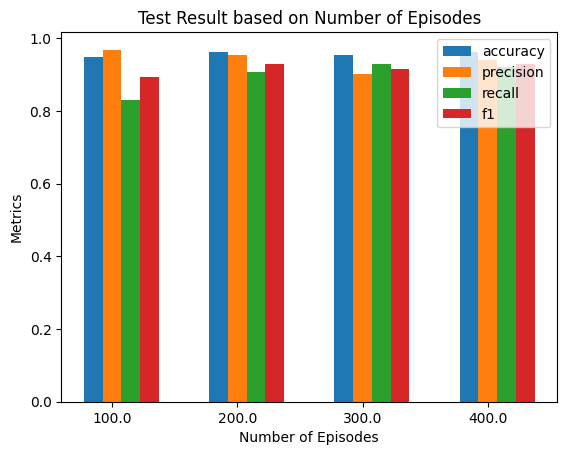

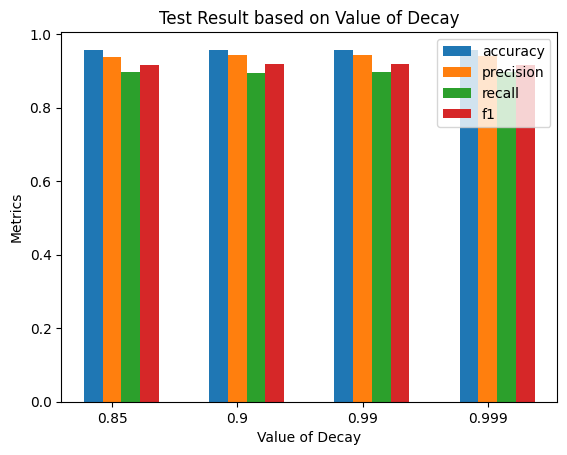

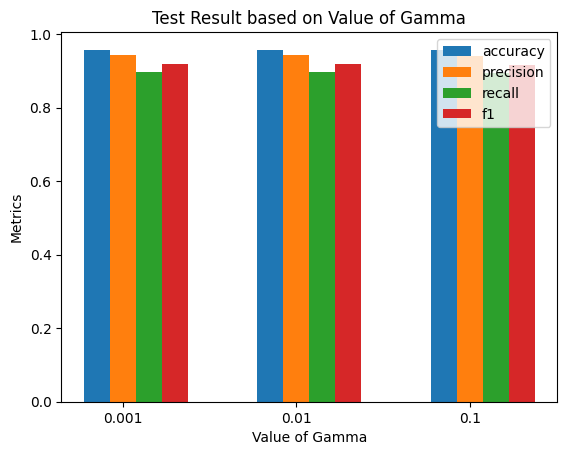

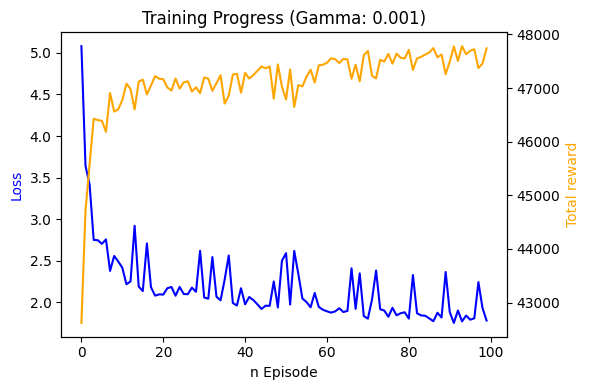

100		0.99		0.001		2.58251		0.95016		0.96805		0.84135		0.90026		


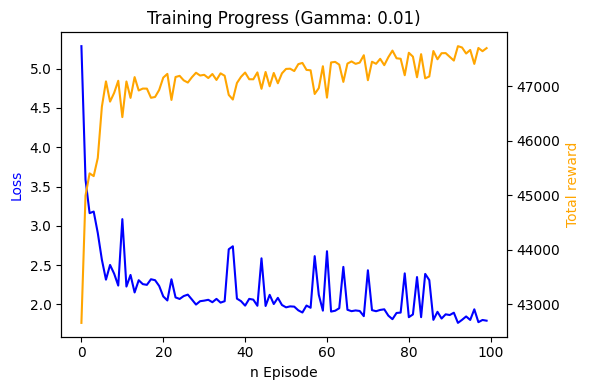

100		0.99		0.01		3.41768		0.95228		0.96938		0.8483		0.90481		


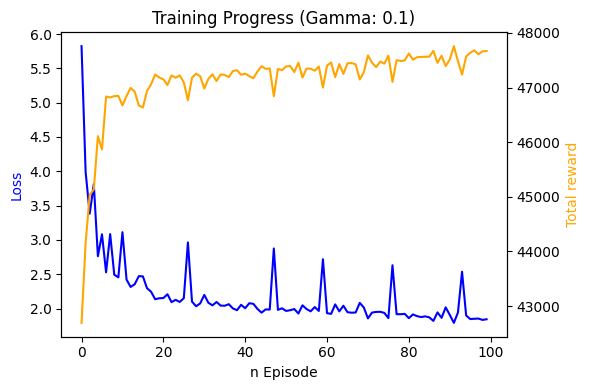

100		0.99		0.1		1.87275		0.94504		0.97572		0.81474		0.88799		


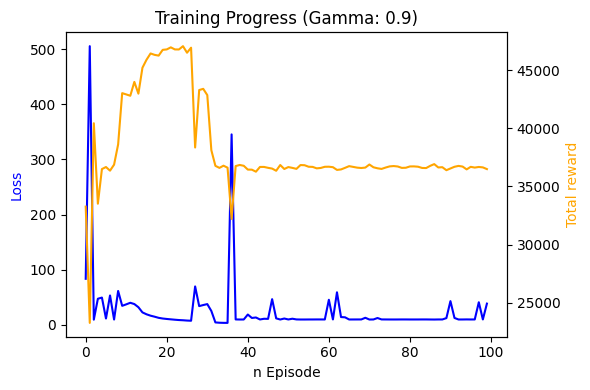

100		0.99		0.9		1.82571		0.73262		0.0		0.0		0.0		


In [ ]:
#plot choice for hyperparameter for DQL
with open("./gdrive/MyDrive/DQL_model_tune/result.csv", "rb") as f:
  retrieved_results = pickle.load(f)

DQL_finetune = pd.DataFrame.from_dict(retrieved_results)
DQL_finetune = DQL_finetune.where(DQL_finetune['gamma'] != 0.9).dropna()
eps_df = DQL_finetune.groupby(['episode']).mean()
decay_df = DQL_finetune.groupby(['decay']).mean()
gamma_df = DQL_finetune.groupby(['gamma']).mean()

def plot_results(feature):
  if feature == 'episode':
    df = eps_df
    title = "Number of Episodes"
    safe_file = './gdrive/MyDrive/DQL_model_tune/num_episodes.eps'
  elif feature == 'decay':
    df = decay_df
    title = "Value of Decay"
    safe_file = './gdrive/MyDrive/DQL_model_tune/decay.eps'
  elif feature == 'gamma':
    df = gamma_df
    title = "Value of Gamma"
    safe_file = './gdrive/MyDrive/DQL_model_tune/gamma.eps'

  n = len(df)
  r = np.arange(n)
  width = 0.15

  # test_time = list(df['score_time'])
  accuracy = list(df['accuracy'])
  precision = list(df['precision'])
  recall = list(df['recall'])
  f1 = list(df['f1'])
  metrics = {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1} #'time':test_time,

  i=0
  for label, metric in metrics.items():
    plt.bar(r + width*i, metric, width=width, label=label)
    i+=1

  plt.xlabel(title)
  plt.ylabel("Metrics")
  plt.title(f"Test Result based on {title}")
  plt.xticks(r + width, list(df.index))
  plt.legend()
  plt.savefig(safe_file, format='eps', dpi=1000)
  plt.show()


plot_results("episode")
plot_results("decay")
plot_results('gamma')

#plot learning of DQL
gammas = [0.001, 0.01, 0.1, 0.9] #

save_file_time = ""
save_label = ""
for gamma in gammas:
  save_file_time = str(round(time()))
  save_label = str(gamma)
  evaluate(num_episodes=100, decay_rate=0.99, gamma=gamma, verbose=0, printing=1, train_test = "train", path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv')

Episode		Decay		Gamma		Time		Accuracy	Precision	Recall		F1
Epoch 000/200 | Loss 5.1128 | Tot reward x episode 36853| Ones/Zeros: 18918/31082 
Epoch 001/200 | Loss 3.0223 | Tot reward x episode 46080| Ones/Zeros: 10225/39775 
Epoch 002/200 | Loss 3.0392 | Tot reward x episode 45706| Ones/Zeros: 10476/39524 
Epoch 003/200 | Loss 2.8122 | Tot reward x episode 45980| Ones/Zeros: 10593/39407 
Epoch 004/200 | Loss 3.3612 | Tot reward x episode 44873| Ones/Zeros: 11184/38816 
Epoch 005/200 | Loss 2.6672 | Tot reward x episode 46528| Ones/Zeros: 11381/38619 
Epoch 006/200 | Loss 2.6894 | Tot reward x episode 46448| Ones/Zeros: 11474/38526 
Epoch 007/200 | Loss 2.2503 | Tot reward x episode 47209| Ones/Zeros: 11094/38906 
Epoch 008/200 | Loss 2.6801 | Tot reward x episode 46405| Ones/Zeros: 11507/38493 
Epoch 009/200 | Loss 2.5186 | Tot reward x episode 46638| Ones/Zeros: 11459/38541 
Epoch 010/200 | Loss 2.5661 | Tot reward x episode 46524| Ones/Zeros: 11606/38394 
Epoch 011/200 | Loss 2.3699 

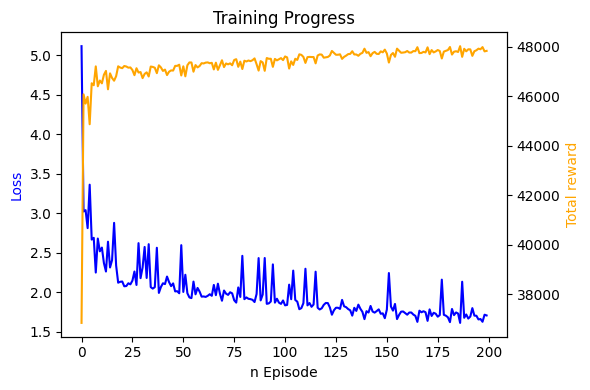

Epoch 399/400 | Ones/Zeros: 49264/143960  Tot Rew -- > 193224
Total reward: 193224 | Number of samples: 200000 | Acuracy = 96.612%
Episode		Decay		Gamma		Time		Accuracy	Precision	Recall		F1
200		0.99		0.001		2.44077		0.96612		0.95051		0.92125		0.93565		
Normalized confusion matrix


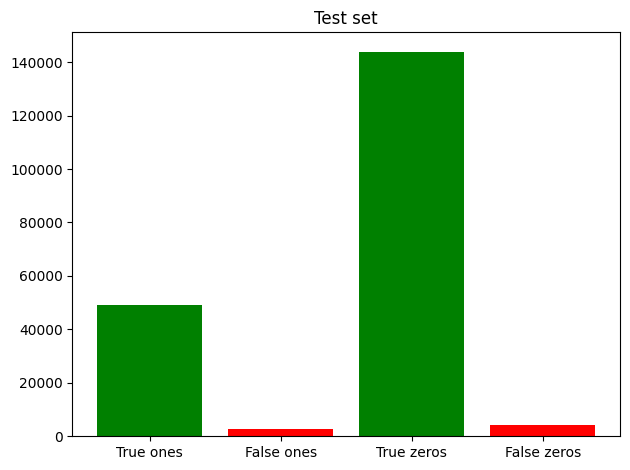

<Figure size 640x480 with 0 Axes>

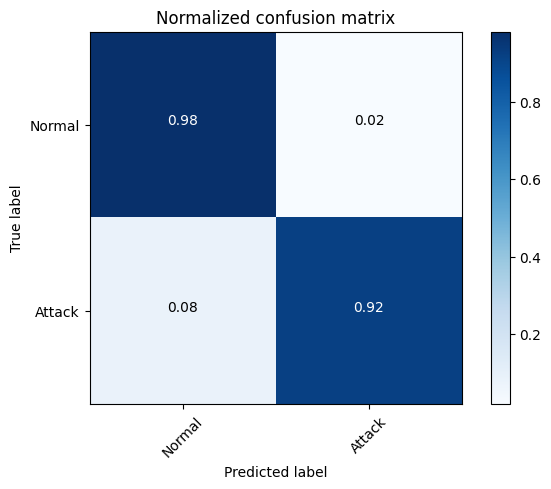

In [ ]:
#plot train/ test result of DQL for chosen hyperparamter after tuning
num_episodes = [200] #best f1 and precision and accuracy
decay_rate = [0.99] #all are the same, don't need show in result
gamma = [0.001] #least loss, good spike on reward

results = []
print(f"Episode\t\tDecay\t\tGamma\t\tTime\t\tAccuracy\tPrecision\tRecall\t\tF1")
for eps in num_episodes:
  for decay in decay_rate:
    for gam in gamma:
      results.append(evaluate(num_episodes=eps, decay_rate=decay, gamma=gam, verbose=1, printing=1, train_test = "train", path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'))

In [ ]:
#Brief evaluation of the top 5 model and SVEM to see their ability before testing

formatted_path = './gdrive/MyDrive/train_gen_feat_multiattack_dataset.csv'
valid_path = './gdrive/MyDrive/test_gen_feat_multiattack_dataset.csv'
top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

X_train = pd.read_csv(formatted_path, usecols=top10)
array = X_train.values
X = array[:, 0:10]
Y = array[:, 10]

valid = pd.read_csv(valid_path, usecols=top10)
array_valid = valid.values
X_valid = array_valid[:, 0:10]
Y_valid = array_valid[:, 10]

In [ ]:
#SVEM Model
classifiers = [
    ('RF', RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_leaf=2, n_estimators=800, random_state=42)),
    ('ET', ExtraTreesClassifier(max_depth=70, min_samples_split=10, n_estimators=800, random_state=42)),
    ('LSVC', LinearSVC(penalty = 'l2', C=0.8, loss='hinge', random_state=42)),
    ('SGD', SGDClassifier(loss='modified_huber', max_iter=2, penalty='l1', random_state=42)),
    ('LR', LogisticRegression(solver= 'lbfgs', C=0.01, random_state=42))
]

#Selecting Algorithms
#IDPS Target models - SGD, RF, DRL
models = []
models.append(('LR', LogisticRegression(solver= 'lbfgs', C=0.01, random_state=42)))
models.append(('SVEM', VotingClassifier(estimators = classifiers, voting='soft')))
models.append(('RF', RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_leaf=2, n_estimators=800, random_state=42)))
models.append(('ET', ExtraTreesClassifier(max_depth=70, min_samples_split=10, n_estimators=800, random_state=42)))
models.append(('LSVC', LinearSVC(penalty = 'l2', C=0.8, loss='hinge', random_state=42)))
models.append(('SGD', SGDClassifier(loss='modified_huber', max_iter=2, penalty='l1', random_state=42)))


#evaluate each model in turn
results = []
names = []
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
           }

print(f"Model\t\tFit time\tScore time\tAccuracy\tPrecision\tRecall\t\tF1")
for name, model in models:
  kfold = KFold(n_splits = 10, random_state = 3, shuffle=True)
  cv_results = cross_validate(model, X, Y, cv=kfold, scoring=scoring, verbose=1)
  results.append(cv_results)
  names.append(name)
  print(name, end="\t\t")
  for key in cv_results.keys():
    print(f"{round(cv_results[key].mean(), 3)}", end="\t\t")
  print()


with open("./gdrive/MyDrive/SVEM_model_tune/result.csv", "wb") as f:
  pickle.dump((results), f)

In [ ]:
#train the model and save their weights
models = []
models.append(('LR', LogisticRegression(solver= 'lbfgs', C=0.01, random_state=42)))
# models.append(('SVEM', VotingClassifier(estimators = classifiers, voting='soft')))
models.append(('RF', RandomForestClassifier(bootstrap=False, max_depth=50, max_features='auto',
                       min_samples_leaf=2, n_estimators=800, random_state=42)))
models.append(('ET', ExtraTreesClassifier(max_depth=70, min_samples_split=10, n_estimators=800, random_state=42)))
models.append(('LSVC', LinearSVC(penalty = 'l2', C=0.8, loss='hinge', random_state=42)))
models.append(('SGD', SGDClassifier(loss='modified_huber', max_iter=2, penalty='l1', random_state=42)))


for name, model in models:
  trained_model = model.fit(X, Y)
  # trained_model.save_weights("./gdrive/MyDrive/SVEM_model_tune/" + name + "model.h5", overwrite=True)
  with open("./gdrive/MyDrive/SVEM_model_tune/" + name + "model.pkl", 'wb') as outfile:
    pickle.dump(trained_model, outfile)

In [ ]:
#Perform validation on the models and observe their performance
def confusion_matrix_plotting(matrix, label, name, classes, cmap=plt.cm.Blues):
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
  group_percentages = ["{0:.2f}%".format(value) for value in matrix.flatten()/np.sum(matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns_plot = sn.heatmap(matrix, annot=labels, fmt='', cmap=cmap)
  sns_plot
  plt.title("Confusion Matrix by " + label + name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classes))+0.5
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.tight_layout()
  plt.savefig('./gdrive/MyDrive/SVEM_model_tune/' + label + name + "matrix.eps", format='eps', dpi=1000)
  plt.show()


for name, model in models:
  with open("./gdrive/MyDrive/SVEM_model_tune/" + name + "model.pkl", 'rb') as jfile:
    model = pickle.load(jfile)


  predicted = model.predict(X_valid)
  matrix = confusion_matrix(Y_valid, predicted)

  confusion_matrix_plotting(matrix = matrix, label = 'Valid_', name = name, classes=['Normal', 'Attack'])

# 10) Unseen Industrial Data Evaluation (TEST)

In [ ]:
traffic = pd.read_csv("./gdrive/MyDrive/vhs-22-network-traffic-dataset.csv", sep=';', index_col=0)

# Sampled and Used Data
multiattack_dataset = pd.read_csv("./gdrive/MyDrive/backups_data/multiattack_dataset.csv")
to_delete = list(multiattack_dataset.loc[:, "Unnamed: 0"])

#delete used columns for training and validation
traffic.drop(to_delete, inplace=True)

In [ ]:
full_attack_fraction = 300000/len(traffic.query("label==1"))
norm_attack_fraction = 1000000/len(traffic)

#create full rare attack list
full_attack_test = traffic.query("label==1").groupby('attack_label', group_keys=False).apply(lambda x:x.sample(frac=full_attack_fraction)) #may lead to problem since model is trained based on 70:30 basis
full_attack_test.sort_values(by=['first_timestamp'], inplace=True)
full_attack_test.set_index(np.arange(0, len(full_attack_test)), inplace=True)
full_attack_test = formating(full_attack_test)

#create adversial network list by following 70:30 with rare attack, and evaluate
norm_attack_test = traffic.groupby('attack_label', group_keys=False).apply(lambda x: x.sample(frac=norm_attack_fraction))
norm_attack_test.sort_values(by=['first_timestamp'], inplace=True)
norm_attack_test.set_index(np.arange(0, len(norm_attack_test)), inplace=True)
norm_attack_test = formating(norm_attack_test)

full_attack_test.to_csv('./gdrive/MyDrive/formated_full_attack_test.csv', index=False)
norm_attack_test.to_csv('./gdrive/MyDrive/formated_norm_attack_test.csv', index=False)

In [ ]:
#Environment Setup
top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

full_attack_test = pd.read_csv('./gdrive/MyDrive/formated_full_attack_test.csv', usecols = top10)
norm_attack_test = pd.read_csv('./gdrive/MyDrive/formated_norm_attack_test.csv', usecols = top10)

full_attack_test = full_attack_test.values
full_attack_X = full_attack_test[:, 0:10]
full_attack_Y = full_attack_test[:, 10]

norm_attack_test = norm_attack_test.values
norm_attack_X = norm_attack_test[:, 0:10]
norm_attack_Y = norm_attack_test[:, 10]

# with open('./gdrive/MyDrive/SVEM_model_tune/SVEMmodel.json', 'r') as jfile:
#   svem_model = model_from_json(json.load(jfile))
# svem_model.load_weights('./gdrive/MyDrive/SVEM_model_tune/SVEMmodel.h5')



with open('./gdrive/MyDrive/SVEM_model_tune/RFmodel.pkl', 'rb') as jfile:
  rf_model = pickle.load(jfile)

with open('./gdrive/MyDrive/SVEM_model_tune/ETmodel.pkl', 'rb') as jfile:
  et_model = pickle.load(jfile)

with open('./gdrive/MyDrive/SVEM_model_tune/LSVCmodel.pkl', 'rb') as jfile:
  lsvc_model = pickle.load(jfile)

with open('./gdrive/MyDrive/SVEM_model_tune/SGDmodel.pkl', 'rb') as jfile:
  sgd_model = pickle.load(jfile)

with open('./gdrive/MyDrive/SVEM_model_tune/LRmodel.pkl', 'rb') as jfile:
  lr_model = pickle.load(jfile)


Epoch 598/599 | Ones/Zeros: 226064/0  Tot Rew -- > 226064
Total reward: 226064 | Number of samples: 299500 | Acuracy = 75.4804674457429%
Episode		Decay		Gamma		Time		Accuracy	Precision	Recall		F1
200		0.99		0.001		4.49172		0.7548		1.0		0.7548		0.86027		
Confusion matrix, without normalization


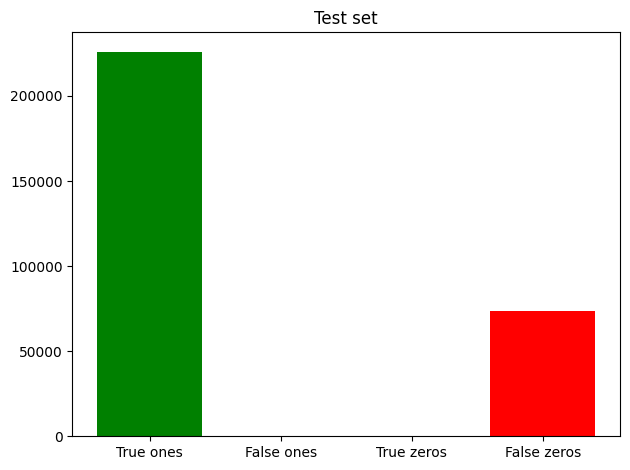

<Figure size 640x480 with 0 Axes>

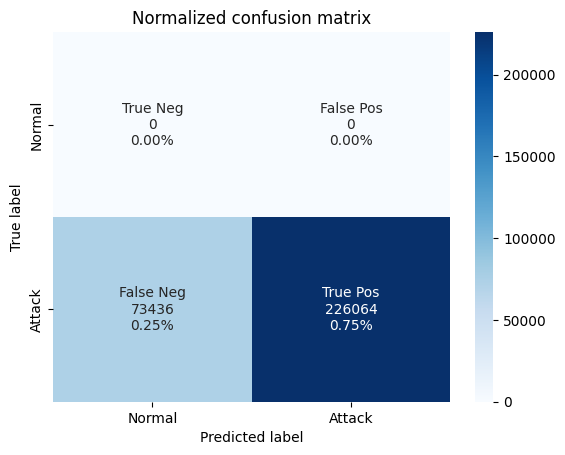

In [ ]:
#Full attack evaluation 1: DQL
dql_performance_attack = evaluate(num_episodes=200, decay_rate=0.99, gamma=0.001, verbose=1, printing=1, train_test = "test", path = './gdrive/MyDrive/formated_full_attack_test.csv', model_name="final_model", customized=True)

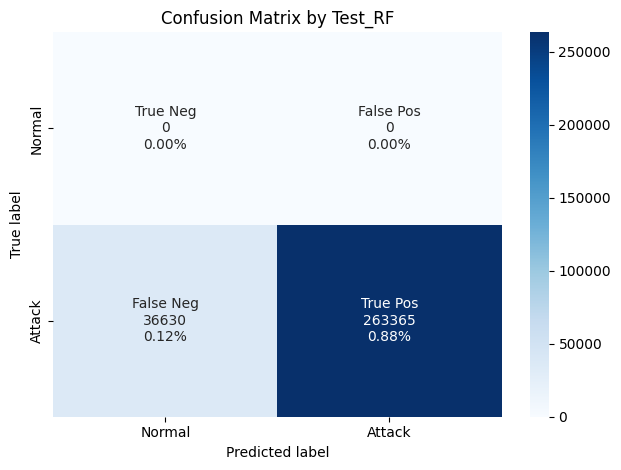

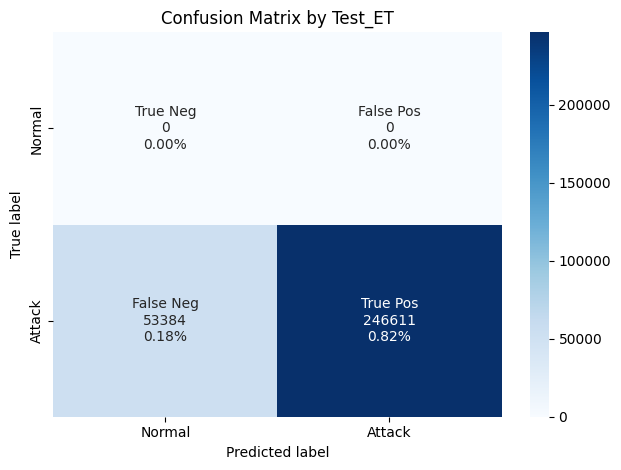

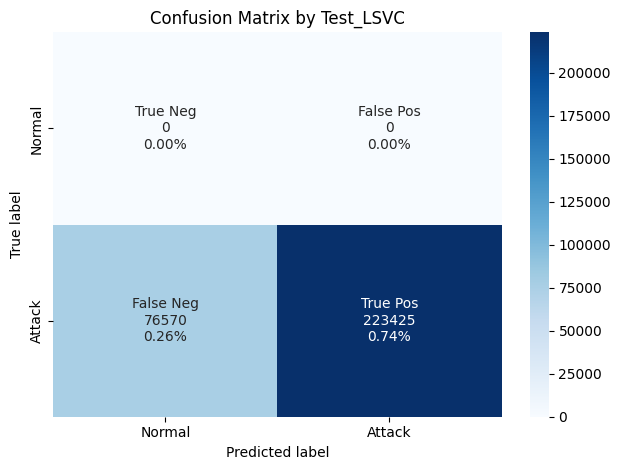

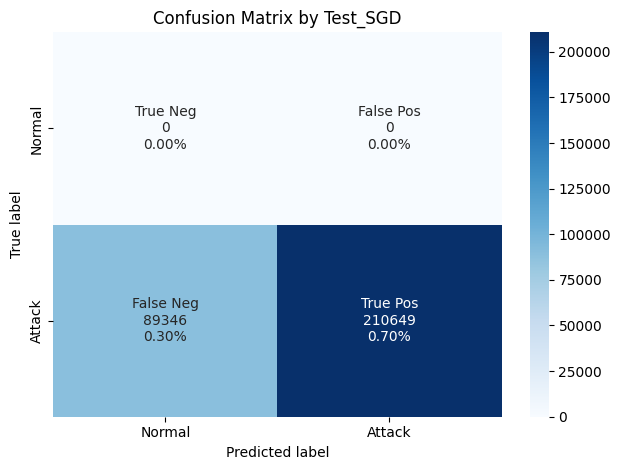

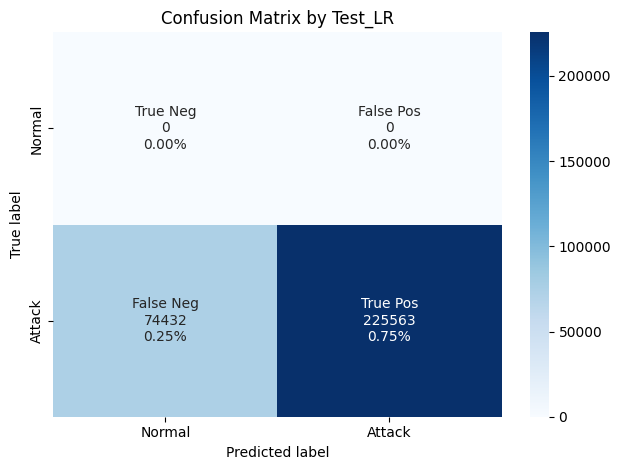

Full attack evaluation on each model
Model	Score time	Accuracy	Precision	Recall		F1
RF	17.8507		0.8779		1.0		0.8779		0.93498		
ET	21.3572		0.82205		1.0		0.82205		0.90234		
LSVC	0.0146		0.74476		1.0		0.74476		0.85371		
SGD	0.0146		0.70218		1.0		0.70218		0.82503		
LR	0.0153		0.75189		1.0		0.75189		0.85838		
DQL	4.4917		0.7548		1.0		0.7548		0.86027		


In [ ]:
#Full attack evaluation 2-7: SVEM, RF, ET, LSVC, SGD, LR
models = []
# models.append(('SVEM', svem_model))
models.append(('RF', rf_model))
models.append(('ET', et_model))
models.append(('LSVC', lsvc_model))
models.append(('SGD', sgd_model))
models.append(('LR', lr_model))

performance_full_attack = []

for name, model in models:
  start = time()
  pred = model.predict(full_attack_X)
  end = time()
  duration = end-start

  report = {
      'model': name,
      'score_time': duration,
      'accuracy': accuracy_score(full_attack_Y, pred),
      'precision': precision_score(full_attack_Y, pred),
      'recall': recall_score(full_attack_Y, pred),
      'f1': f1_score(full_attack_Y, pred)
  }
  performance_full_attack.append(report)
  matrix = confusion_matrix(full_attack_Y, pred)
  confusion_matrix_plotting(matrix=matrix, label='Test_', name=name, classes=['Normal', 'Attack'])

performance_full_attack.append({
    'model': "DQL",
    'score_time': dql_performance_attack['score_time'],
    'accuracy': dql_performance_attack['accuracy'],
    'precision': dql_performance_attack['precision'],
    'recall': dql_performance_attack['recall'],
    'f1': dql_performance_attack['f1']
})

print("Full attack evaluation on each model")
print(f"Model\tScore time\tAccuracy\tPrecision\tRecall\t\tF1")
for test_result in performance_full_attack:
  for keys, values in test_result.items():
    if type(values) == str:
      print(f"{values}", end="\t")
    elif keys == "score_time":
      print(f"{round(values, 5):.4f}", end="\t\t")
    else:
      print(f"{round(values, 5)}", end="\t\t")
  print()

with open('./gdrive/MyDrive/Model_test_performance/performance_full_attack.csv', 'wb') as outfile:
  pickle.dump((performance_full_attack), outfile)

Epoch 1999/2000 | Ones/Zeros: 245505/720465  Tot Rew -- > 965970
Total reward: 965970 | Number of samples: 1000000 | Acuracy = 96.597%
Episode		Decay		Gamma		Time		Accuracy	Precision	Recall		F1
200		0.99		0.001		20.67596		0.96597		0.9501		0.92073		0.93519		
Confusion matrix, without normalization


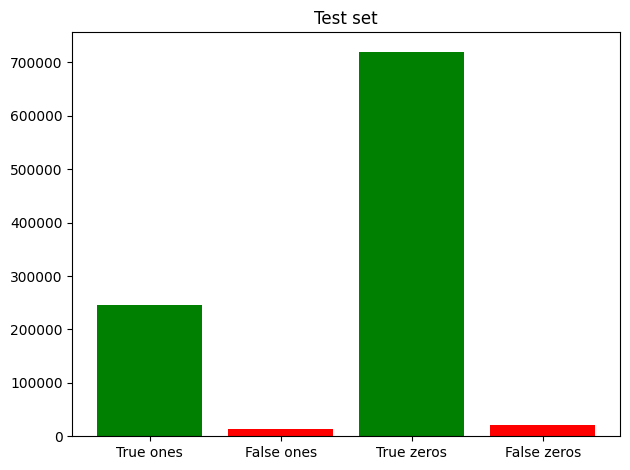

<Figure size 640x480 with 0 Axes>

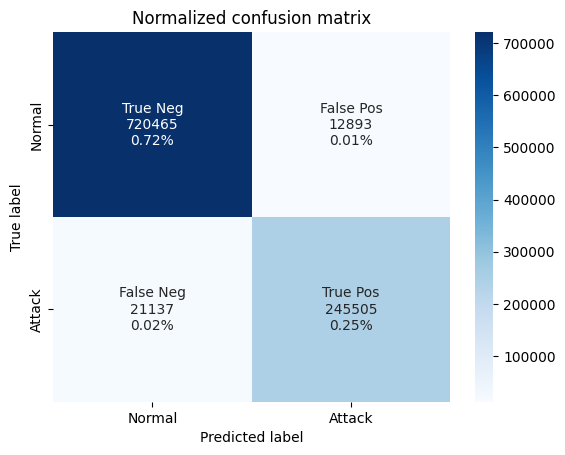

In [ ]:
#Adversial network with normal and attack attack evaluation 1: DQL
dql_performance_norm_att = evaluate(num_episodes=200, decay_rate=0.99, gamma=0.001, verbose=1, printing=1, train_test = "test", path = './gdrive/MyDrive/formated_norm_attack_test.csv', model_name="final_model", customized=True)

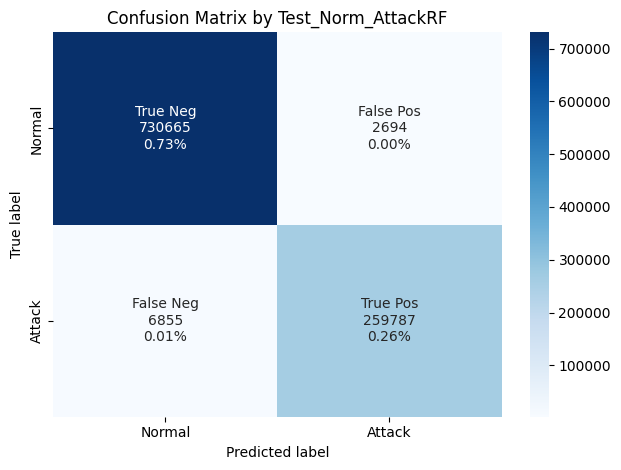

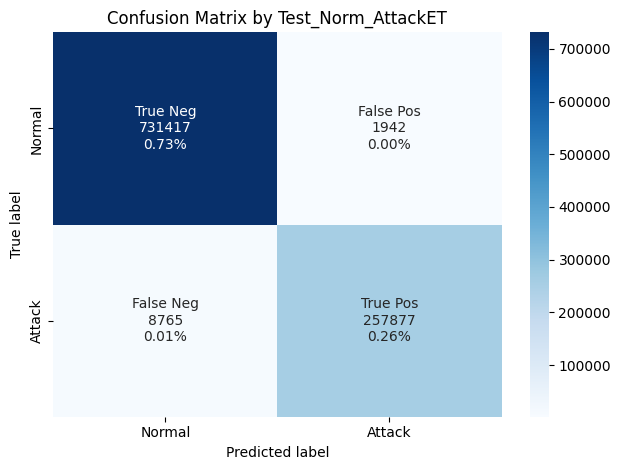

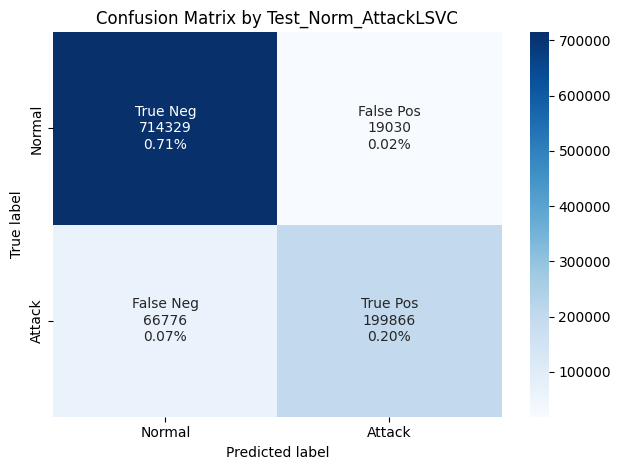

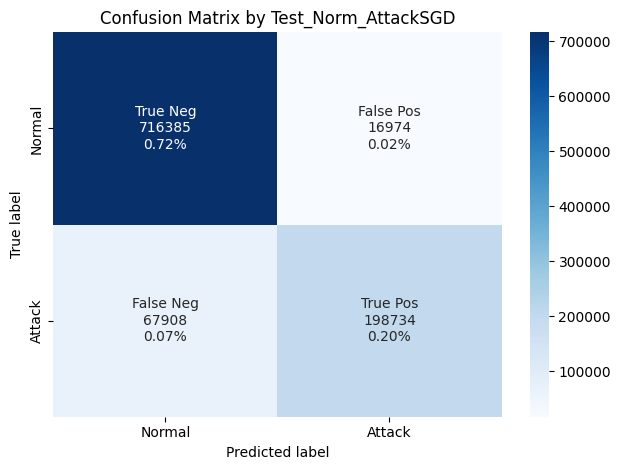

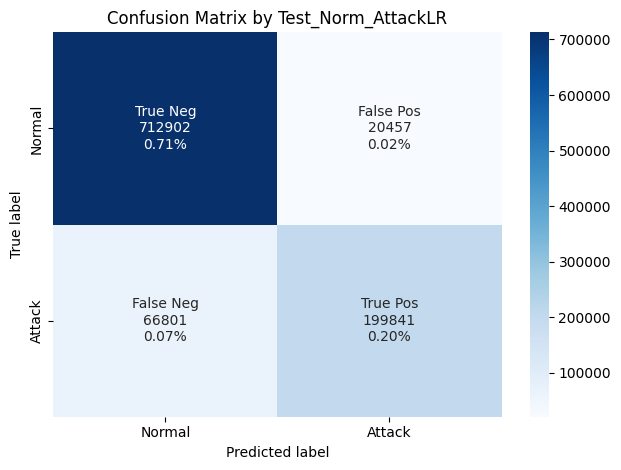

Full attack evaluation on each model
Model	Score time	Accuracy	Precision	Recall		F1
RF	129.2180		0.99045		0.98974		0.97429		0.98195		
ET	177.9482		0.98929		0.99253		0.96713		0.97966		
LSVC	0.0322		0.91419		0.91306		0.74957		0.82328		
SGD	0.0348		0.91512		0.92131		0.74532		0.82402		
LR	0.0279		0.91274		0.90714		0.74947		0.8208		
DQL	20.6760		0.96597		0.9501		0.92073		0.93519		


In [ ]:
#Adversial network with normal and attack attack evaluation 2-7: SVEM, RF, ET, LSVC, SGD, LR
performance_norm_attack = []

for name, model in models:
  start = time()
  pred = model.predict(norm_attack_X)
  end = time()
  duration = end-start

  report = {
      'model': name,
      'score_time': duration,
      'accuracy': accuracy_score(norm_attack_Y, pred),
      'precision': precision_score(norm_attack_Y, pred),
      'recall': recall_score(norm_attack_Y, pred),
      'f1': f1_score(norm_attack_Y, pred)
  }
  performance_norm_attack.append(report)
  matrix = confusion_matrix(norm_attack_Y, pred)
  confusion_matrix_plotting(matrix=matrix, label='Test_Norm_Attack', name=name, classes=['Normal', 'Attack'])

performance_norm_attack.append({
    'model': "DQL",
    'score_time': dql_performance_norm_att['score_time'],
    'accuracy': dql_performance_norm_att['accuracy'],
    'precision': dql_performance_norm_att['precision'],
    'recall': dql_performance_norm_att['recall'],
    'f1': dql_performance_norm_att['f1']
})

print("Full attack evaluation on each model")
print(f"Model\tScore time\tAccuracy\tPrecision\tRecall\t\tF1")
for test_result in performance_norm_attack:
  for keys, values in test_result.items():
    if type(values) == str:
      print(f"{values}", end="\t")
    elif keys == "score_time":
      print(f"{round(values, 5):.4f}", end="\t\t")
    else:
      print(f"{round(values, 5)}", end="\t\t")
  print()

with open('./gdrive/MyDrive/Model_test_performance/performance_norm_attack.csv', 'wb') as outfile:
  pickle.dump((performance_norm_attack), outfile)

# 11) Power BI & Streamlit


In [3]:
!pip install -q streamlit
import streamlit as st

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00


In [4]:
mkdir pages

In [5]:
%%writefile App.py

import streamlit as st
import pandas as pd

st.set_page_config(
  page_title="Introduction",
  page_icon="👋",
)

col1, col2 = st.columns([25, 1])
with col1:
  st.write("# Welcome to DQLearnCapable")
with col2:
  st.image("./gdrive/MyDrive/images/logo.png", width=60)

st.sidebar.success("Navigation")
st.sidebar.write("Page 1 - Dashboard")
st.sidebar.write("Page 2 - Exploratory Data Analysis")
st.sidebar.write("Page 3 - Model Performance")
st.sidebar.write("Page 4 - Playground")

st.write("Threat Detector")
st.image("./gdrive/MyDrive/images/Cover_Page.jpg")

st.write("### Background")
st.write("As the technology has become advanced, variation of cyber threats has come to the surface of the networking world, posing new and dynamic attack challenges to network users. Hence, there is a demand for AI-assisted or self-governing threat detection systems that have capability of adaptive learning. Several reinforcement learning methods and traditional machine learning (ML) based methods for automated threat detection systems have been proposed in recent years. In this study, we introduce a new generation of threat detection methods with adaptive learning capability, which combines Q-learning of reinforcement learning with deep neural networks. The proposed Deep Q-Learning (DQL) model learns through a subset of the environment iteratively using trial-error approach to optimize its decision making. Several traditional ML-based approaches are built for benchmarking purposes. Through intensive comparison based on VHS-22 dataset, we can confirm that Random Forest Classifier (RF) and Extra Tree Classifier (ET) yield slightly better performance than DQL but DQL still outperforms other similar ML approaches. Another focus in this paper is to improve generalizability of the model, where we use heterogeneous datasets to train DQL with adaptive learning capability.")

st.markdown("### Navigation")
st.dataframe(pd.DataFrame({
    "Pages": ["Dashboard",
              "Exploratory Data Analysis",
              "Model Performance",
              "Playground",
              ],

    "Description": ["Embedded PowerBI interactive dashboard. Overview of Network Analysis.",
                    "Datasets used in DQLearnCapable and important features to identify threats.",
                    "Performance evaluation of 6 ML models.",
                    "Play around with embedded ML models to detect threats in your PCAP file.",
                    ]

  }))


Writing App.py


In [6]:
%%writefile pages/Dashboard.py
import streamlit as st

st.set_page_config(
  page_title="Network Dahsboard",
  page_icon="📊",
  layout="wide")

st.markdown("# Network Dashboard")
st.sidebar.header("Network Dashboard")
st.write("""
  Network Analysis Dahsboard
""")

st.components.v1.html("""
    <iframe title="Report Section" width="1024" height="612" src="https://app.powerbi.com/view?r=eyJrIjoiNjA3ZGMyMDgtMzg4My00ZDUxLWE2MDMtNmMwOWM3YjRhY2Q3IiwidCI6ImE2M2JiMWE5LTQ4YzItNDQ4Yi04NjkzLTMzMTdiMDBjYTdmYiIsImMiOjEwfQ%3D%3D" frameborder="0" allowFullScreen="true"></iframe>
  """,
  height=612
  )



Writing pages/Dashboard.py


In [7]:
%%writefile pages/EDA_Data.py
import streamlit as st
import pandas as pd
import altair as altair
from urllib.error import URLError
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(
  page_title="Exploratory Data Analysis",
  page_icon="📊"
)

st.markdown("## Exploratory Data Analysis")
st.sidebar.header("Exploratory Data Analysis")
st.write(
  """This demo shows dataset used by this project. """
)

@st.cache_data
def get_network_data():
  df = pd.read_csv('./gdrive/MyDrive/norm_attack_test.csv')
  df_formated = pd.read_csv('./gdrive/MyDrive/formated_norm_attack_test.csv')
  return df

@st.cache_data
def get_formated_network_data():
  df_formated = pd.read_csv('./gdrive/MyDrive/formated_norm_attack_test.csv')
  return df_formated



try:

  top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

  df = get_network_data()
  df_formated=get_formated_network_data()

  st.write("### Dataset Description")
  st.dataframe(pd.DataFrame({
    "Aspect": ["Name",
              "Integrated Dataset",
              "Size",
              "Sampled Size",
              "Features",
              "No. Features",
              "Author",
              "Year Created",
              "Time Span",
              "License"
              ],

    "Description": ["VHS-22",
                    "ISOT, CICIDS2017, Booters, CTU-13, MTA",
                    "27.7 million (20.3 million legitimate and 7.4 million attacks)",
                    "1 million (733k legitimate and 267k attack)",
                    "Flow-level and Network-level information",
                    "45 + 3 (labels)",
                    "Paweł Szumełda, Natan Orzechowski, Mariusz Rawski, and Artur Janicki",
                    "2022",
                    "1 Jan 2022 - 23 Jan 2022",
                    "Attribution 4.0 International (CC BY 4.0)"
                    ]

  }))

  st.write("### Network Traffic Flow Dataset Overview", df.head(10))

  st.write("### Statistical Summary", df.describe())

  xticklabels = ['1','2','3','4','5','6','7','8','9','10', 'label']
  yticklabels = ['ip_p[1]', 'sport[2]', 'b_p_max[3]', 'b_p_med[4]',
       'b_p_3q[5]', 'con_f_p[6]',
       'con_r_to_h[7]', 'con_r_f_p[8]',
       'PCA1[9]', 'MDSAE2[10]', 'label']

  st.write("### Correlation Graph of Chosen Features")
  fig, ax = plt.subplots()
  sns.heatmap(df_formated[top10].corr(), annot=True, cmap="coolwarm", xticklabels=xticklabels, yticklabels=yticklabels)
  st.pyplot(fig)

  st.write("### Metadata of Chosen Features")
  st.write("10 most correlated features are chosen through the variance threshold filter, chi-squared filter and pairwise correlation function.")
  table = pd.DataFrame({
    "Features": ['ip_protocol',
                 'sport',
                 'b_packet_max',
                 'b_packet_median',
                 'b_packet_third_q',
                 'connections_from_this_port',
                 'connections_ratio_to_this_host',
                 'connections_ratio_from_this_port',
                 'PCA1',
                 'MDSAE2',
                 'label'],

    "Acronym": ['ip_p[1]',
                'sport[2]',
                'b_p_max[3]',
                'b_p_med[4]',
                'b_p_3q[5]',
                'con_f_p[6]',
                'con_r_to_h[7]',
                'con_r_f_p[8]',
                'PCA1[9]',
                'MDSAE2[10]',
                'label'],

    "Description": ["Fourth layer protocol",
                    "Source port",
                    "Size of the largest packet",
                    "Median packet size",
                    "3rd quantile of packet size",
                    "No. of connections with the same source port number",
                    "% of connections from the host with the same source address",
                    "% of connections from host with the same source port",
                    "Engineered feature by principal component analysis using 45 original features",
                    "Engineered feature by multi-noise autoenconder using 45 original features",
                    'Label for Attack or Normal traffic.']

    })
  st.table(table)



except URLError as e:
  st.error(
    """**This demo requires internet access. **
    Connection error: %s
    """
    % e.reason
  )


Writing pages/EDA_Data.py


In [8]:
%%writefile pages/Model_Performance.py

import streamlit as st
import time
import pickle
import numpy as np
import plotly.graph_objects as go
import pandas as pd

@st.cache_data
def get_performance_data(file):
  with open(file, 'rb') as outfile:
    df = pickle.load(outfile)
  df = pd.DataFrame(df)
  return df

st.set_page_config(
  page_title="Model Performance",
  page_icon="📈",
)

st.markdown("## Model Performance")
st.write("""This demo illustrates a model performance. Enjoy!""")

st.sidebar.header("Model Performance")
with st.sidebar:
  type_performance = st.radio(
    "See performance based on:",
    ("Attack Network Flow only (0N:100A)", "Attack and Normal Network Flow (70N:30A)")
  )

if type_performance == "Attack Network Flow only (0N:100A)":
  df = get_performance_data("./gdrive/MyDrive/Model_test_performance/performance_full_attack.csv")
else:
  df = get_performance_data("./gdrive/MyDrive/Model_test_performance/performance_norm_attack.csv")

categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig = go.Figure()

for i in range(len(df)):
  fig.add_trace(go.Scatterpolar(
      r = df.iloc[[i]].values[:, 2:6][0],
      theta = categories,
      fill = 'toself',
      name = df.iloc[[i]].values[:, 0][0]
  ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=False
        )
    ),
    showlegend=True
)

fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x = df['model'].values,
    y = df['accuracy'].values*100,
    name="Accuracy"
))

fig2.add_trace(go.Bar(
    x = df['model'].values,
    y = df['precision'].values*100,
    name="Precision"
))

fig2.add_trace(go.Bar(
    x = df['model'].values,
    y = df['recall'].values*100,
    name="Recall"
))

fig2.add_trace(go.Bar(
    x = df['model'].values,
    y = df['f1'].values*100,
    name="F1 Score"
))

fig2.add_trace(go.Scatter(
    x = df['model'].values,
    y = df['score_time'].values,
    name="Score Time (s)",
    connectgaps=True
))



st.write("### Performance Overview",fig)
st.write("### Model Performance with Time", fig2)
st.write("### Model Evaluation Details")
st.dataframe(df, use_container_width=True)

st.write("")
st.write("### Details of each model")

with st.expander("##### Deep Q-Learning Based Reinforcement Learning (DQL)"):
  st.write("Deep Q-Learning (DQL) model provides an ongoing auto-learning capability for a network environment that can detect different types of network intrusions using an automated trial-error approach and continuously enhance its detection capabilities.")
  st.write("")
  st.write("Flow Chart")
  st.image("./gdrive/MyDrive/images/Figure 7 DQL traning flow chart.png")
  st.write("")
  st.write("Model Diagram")
  st.image("./gdrive/MyDrive/images/Figure 8 DQL learning process.png")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["Neural Network Layer",
                       "Hidden Layer Size",
                       "Batch Size",
                       "Number of Episode",
                       "Episode Iteration",
                       "Epsilon",
                       "Decay Rate",
                       "Gamma",
                       ],

    "Value": ["4 [Input, Hidden, Hidden, Output]",
              "100",
              "500",
              "200",
              "100",
              "0.1",
              "0.99",
              "0.001",
              ],

    "Description": ["This refers to the number of layers in the neural network used to approximate the Q-function in DQL. The complexity of the problem often dictates the number of layers.",
                    "This is the number of neurons in each hidden layer of the neural network. A larger size can increase the capacity of the model to learn complex patterns, but it may also lead to overfitting.",
                    "This is the number of experiences sampled from the memory to train the network at each step. A larger batch size can lead to more stable updates, but it also requires more computational resources.",
                    "This is the number of complete sequences of interaction between the agent and the environment. Each episode is a complete game or sequence from start to finish.",
                    "This refers to the maximum number of steps in each episode. It determines how long an episode can last",
                    "This is the exploration rate in the epsilon-greedy policy. It determines the probability of taking a random action. A high epsilon value encourages more exploration, while a low value encourages more exploitation. The epsilon will change over the training period based on gamma and decay rate",
                    "This is the rate at which epsilon decreases over time. A high decay rate makes the agent shift from exploration to exploitation more quickly",
                    "This is the discount factor used in the Q-learning update. It determines the importance of future rewards. A gamma close to 0 makes the agent short-sighted by only considering current rewards, while a gamma close to 1 makes the agent aim for long-term rewards",
                    ]

  }))

with st.expander("##### Random Forest Classifier (RF)"):
  st.write("A Random Forest Classifier (RF) is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["n_estimators",
                       "min_samples_split",
                       "min_samples_leaf",
                       "max_features",
                       "max_depth",
                       "bootstrap",
                       ],

    "Value": ["800",
              "2",
              "2",
              "auto",
              "50",
              "False",
              ],

    "Description": ["The number of trees in the forest. More trees can lead to better performance but also to longer computation time.",
                    "The minimum number of samples required to split an internal node. If the value is an integer, it is considered as the minimum number. If it's a float, it's a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.",
                    "The minimum number of samples required to be at a leaf node. This parameter prevents splitting nodes in a way that it leaves too few samples in any of the child nodes.",
                    "The number of features to consider when looking for the best split. It can be an integer, float or string (sqrt, log2, None).",
                    "The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.",
                    "Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree."
                    ]

  }))

with st.expander("##### Extra Tree Classifier (ET)"):
  st.write("The Extra Tree Classifier (ET) a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["n_estimators",
                       "min_samples_split",
                       "min_samples_leaf",
                       "max_features",
                       "max_depth",
                       "bootstrap",
                       ],

    "Value": ["800",
              "10",
              "1",
              "sqrt",
              "70",
              "False",
              ],

    "Description": ["The number of trees in the forest. More trees can lead to better performance but also to longer computation time.",
                    "The minimum number of samples required to split an internal node. If the value is an integer, it is considered as the minimum number. If it's a float, it's a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.",
                    "The minimum number of samples required to be at a leaf node. This parameter prevents splitting nodes in a way that it leaves too few samples in any of the child nodes.",
                    "The number of features to consider when looking for the best split. It can be an integer, float or string (sqrt, log2, None).",
                    "The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.",
                    "Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree."
                    ]

  }))

with st.expander("##### Linear Support Vector Machine (LSVC)"):
  st.write("Linear Support Vector Machine (LSVC) is a supervised machine learning algorithm specifically designed for classifying linearly separable data. It constructs a hyperplane in high-dimensional space that separates different classes with the largest margin possible, aiming for a robust and generalizable model.")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["penalty",
                       "loss",
                       "C",
                       ],

    "Value": ["l2",
              "hinge",
              "0.8",
              ],

    "Description": ["Controls the type of regularization used to prevent overfitting. L2 regularization (Ridge) encourages smaller weights overall, making the model less sensitive to outliers.",
                    "Specifies the loss function used to measure model errors during training. The 'hinge' is standard hinge loss for SVMs",
                    "Inverse of regularization strength. Higher C values prioritize minimizing training errors, increasing model complexity. Lower C values emphasize regularization, reducing model complexity and potentially improving generalization.",
                    ]

  }))

with st.expander("##### Stochastic Gradient Descent (SGD)"):
  st.write("Stochastic Gradient Descent (SGD) is an efficient optimization algorithm often used to train machine learning models, especially with large datasets. It iteratively updates model parameters to minimize a loss function, but unlike traditional gradient descent, it processes data samples one at a time (or in small batches) rather than the entire dataset in each iteration. This makes it faster and more memory-efficient, especially for large-scale problems.")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["penalty",
                       "loss",
                       "max_iter",
                       ],

    "Value": ["l1",
              "modified_huber",
              "2",
              ],

    "Description": ["Specifies the type of regularization to apply. L1 regularization for potential feature selection.",
                    "Determines the loss function used to measure error during training. ",
                    "Sets the maximum number of iterations (epochs) for the training process.",
                    ]

  }))

with st.expander("##### Logistic Regression (LR)"):
  st.write("Logistic Regression (LR) is a popular statistical method used for binary classification tasks. It estimates the probability of an instance belonging to a particular class (usually 0 or 1) based on its features. It's known for its interpretability and relatively simple implementation.")
  st.write("")
  st.write("Hyperparameter")
  st.dataframe(pd.DataFrame({
    "Hyperparameter": ["solver",
                       "C",
                       ],

    "Value": ["lbfgs",
              "0.01",
              ],

    "Description": ["Specifies the algorithm used to optimize the model's parameters. 'lbfgs': Limited-memory BFGS, an approximation of Newton's method that's less memory-intensive.",
                    "Inverse of regularization strength.",
                    ]

  }))


Writing pages/Model_Performance.py


In [9]:
%%writefile pages/Playground.py

import streamlit as st
import pandas as pd
import pydeck as pdk
from urllib.error import URLError
from tensorflow import keras
import numpy as np
import joblib
import tensorflow as tf
from keras.models import model_from_json
import pickle
import json

top10 = ['ip_protocol', 'sport', 'b_packet_max', 'b_packet_median',
       'b_packet_third_q', 'connections_from_this_port',
       'connections_ratio_to_this_host', 'connections_ratio_from_this_port',
       'PCA1', 'MDSAE2', 'label']

def formating (X):
    @keras.saving.register_keras_serializable(package="MyLayers")
    class Sampling(keras.layers.Layer):
      def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

    X = X

    columns = ["ip_src_str", "ip_dst_str", "ip_protocol", "sport", "dport", "in_packets",
            "b_packet_total", "first_timestamp", "last_timestamp", "duration", "flags_sum",
            "urg_nr_count", "ack_nr_count", "rst_nr_count", "fin_nr_count", "psh_nr_count", "syn_nr_count",
            "b_packet_max", "b_packet_min", "b_packet_mean", "b_packet_median", "b_packet_first_q",
            "b_packet_third_q", "b_packet_std", "iat_min", "iat_max", "iat_first_q",
            "iat_third_q", "iat_std", "iat_mean", "iat_median", "iat_var",
            "connections_from_this_host", "connections_to_this_host", "connections_rst_to_this_host",
            "connections_rst_from_this_host", "connections_to_this_port", "connections_from_this_port",
            "connections_ratio_from_this_host", "connections_ratio_to_this_host", "connections_ratio_rst_to_this_host",
            "connections_ratio_rst_from_this_host", "connections_ratio_to_this_port", "connections_ratio_from_this_port",
            "label", "attack_label", "attack_file"]

    X = X.reindex(columns=columns)

    to_drop = ['connections_ratio_rst_from_this_host', #0 values, meaningless
            'connections_rst_from_this_host', #0 values, meaningless
            'iat_third_q', #0 values, meaningless
            'iat_first_q', #0 values, meaningless
            "urg_nr_count", #covered by flags_sum
            "ack_nr_count", #covered by flags_sum
            "rst_nr_count", #covered by flags_sum
            "fin_nr_count", #covered by flags_sum
            "psh_nr_count", #covered by flags_sum
            "syn_nr_count", #covered by flags_sum
            "attack_label",
            "attack_file",
            "Unnamed: 0.1",
            "Unnamed: 0"
          ]

    X.drop(columns=to_drop, axis=1, inplace=True, errors='ignore')

    ori_label = X.columns[2:34]
    ori_label = ori_label.drop(['first_timestamp', 'last_timestamp'], errors='ignore')

    array = X.values
    X_train = array[:, 2:34]
    X_train = np.delete(X_train, [5,6], axis=1)#ip address and timestamp data excluded
    y_train = array[:, 34]
    y_train = y_train.astype('int32')

    # joblib.dump(norm_scaler, './gdrive/MyDrive/clean/scaler.save')
    norm_scaler = joblib.load('./gdrive/MyDrive/clean/scaler.save')
    n_X_train = norm_scaler.transform(X_train)

    # var_encoder.save('./gdrive/MyDrive/clean/var_encoder_v1.h5')
    var_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/var_encoder_v1.h5', compile=False)
    encoded = var_encoder
    gen_feat = encoded.predict(n_X_train)
    gen_featdf = pd.DataFrame(gen_feat)
    # joblib.dump(norm_scaler4, './gdrive/MyDrive/clean/vae_scaler.save')
    norm_scaler4 = joblib.load('./gdrive/MyDrive/clean/vae_scaler.save')
    n_gen_feat = norm_scaler4.transform(gen_feat)
    n_gen_feat = pd.DataFrame(n_gen_feat)
    new_col_headers = ["VAE1", "VAE2", "VAE3", "VAE4"]
    n_gen_feat.columns = new_col_headers

    # joblib.dump(pca, './gdrive/MyDrive/clean/pca.sav')
    pca = joblib.load('./gdrive/MyDrive/clean/pca.sav')
    X_pca_train = pca.fit_transform(n_X_train)
    pca_featdf = pd.DataFrame(X_pca_train)
    # joblib.dump(norm_scalerpca, './gdrive/MyDrive/clean/pca_scaler.save')
    norm_scalerpca = joblib.load('./gdrive/MyDrive/clean/pca_scaler.save')
    n_pca_feat = norm_scalerpca.transform(pca_featdf)
    n_pca_feat = pd.DataFrame(n_pca_feat)
    new_col_headers = ["PCA1", "PCA2"]
    n_pca_feat.columns = new_col_headers

    # mdsae_encoder.save('./gdrive/MyDrive/clean/mdsae_encoder.h5')
    mdsae_encoder = tf.keras.models.load_model('./gdrive/MyDrive/clean/mdsae_encoder.h5', compile=False)
    mdsae_encoded = mdsae_encoder
    mdsae_gen_feat = mdsae_encoded.predict(n_X_train)
    mdsae_gen_featdf = pd.DataFrame(mdsae_gen_feat)
    # joblib.dump(norm_scaler_ae, './gdrive/MyDrive/clean/mdsae_scaler.save')
    norm_scaler_ae = joblib.load('./gdrive/MyDrive/clean/mdsae_scaler.save')
    n_mdsae_gen_feat = norm_scaler_ae.transform(gen_feat)
    n_mdsae_gen_feat = pd.DataFrame(n_mdsae_gen_feat)
    new_col_headers = ["MDSAE1", "MDSAE2", "MDSAE3", "MDSAE4"]
    n_mdsae_gen_feat.columns = new_col_headers

    n_ori_feat = pd.DataFrame(n_X_train, columns = ori_label)
    feat_label = pd.DataFrame(y_train, columns=["label"])
    whole_all_feat = pd.concat([n_ori_feat, n_gen_feat, n_pca_feat, n_mdsae_gen_feat, feat_label], axis=1)
    whole_all_feat['label'] = pd.to_numeric(whole_all_feat['label'])

    return whole_all_feat

st.set_page_config(
  page_title="Playground",
  page_icon="🌍"
  )

st.markdown("## IP Threat Detector")
st.sidebar.header("Playground")
st.write("""This demo shows ip threat detection using selected models""")

@st.cache_data
def get_model(model_file, json_file=None):
  if json_file != None:
    with open("./gdrive/MyDrive/DQL_model_tune/models/" + model_file + ".json", "r") as jfile:
      model = model_from_json(json.load(jfile))
    model.load_weights("./gdrive/MyDrive/DQL_model_tune/models/" + model_file + ".h5")
  else:
    with open('./gdrive/MyDrive/SVEM_model_tune/' + model_file + 'model.pkl', 'rb') as jfile:
      model = pickle.load(jfile)
  return model

def back_color_text(text, color):
   st.markdown(f'<p style="background-color:{color};text-indent: 50px;border-radius:2%;">{text}</p>', unsafe_allow_html=True)

try:

  #st input for a csv file
  uploaded_file = st.file_uploader("Choose a CSV file")
  if uploaded_file is not None:
    features = pd.read_csv(uploaded_file)
    st.write("### Extracted Data from Network Packet", features)
    dest_ip_address = features['ip_dst_str'][0]
    src_ip_address = features['ip_src_str'][0]
    features = features.append(features)
    formated = formating(features)
    states = formated[top10]
    del(states['label'])
    st.write("### Formated features for ML detection", states.iloc[[0]])


  #st selectbox for a model
  st.write("### Choose a Machine Learning Model for Threat Detection")
  option = st.selectbox(
    "### Choose a Machine Learning Model for Threat Detection",
    ("DQL", "RF", "ET", "LSVC", "SGD", "LR"),
    index=None,
    placeholder="Select a ML model...",
    label_visibility="collapsed",
  )

  st.write("### Actions")
  st.write("Act now or it will be too late!")

  if option == "DQL":
    model = get_model("final_model", "final_model")
    q = model.predict(states.iloc[[0]])
    actions = np.argmax(q, axis=1, )
    if actions == 1:
      back_color_text(f""" <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Threat Detected. Suspected IP Address: {dest_ip_address} <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Please shut down {src_ip_address} immediately <br> .
      """,
      "#FF0000")
    else:
      back_color_text(f""" <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp This network flow is safe from threat <br> .
      """, "#008000")


  if option in ["RF", "ET", "LSVC", "SGD", "LR"]:
    model = get_model(option)
    q = model.predict(states.iloc[[0]])
    actions = q
    if actions == 1:
      back_color_text(f""" <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Threat Detected. Suspected IP Address: {dest_ip_address} <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp Please shut down {src_ip_address} immediately <br> .
      """,
      "#FF0000")
    else:
      back_color_text(f""" <br>
      &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp This network flow is safe from threat <br> .
      """, "#008000")

except URLError as e:
  st.error(
    """
    **This demo requires internet access.##
    Connection error: %s
    """
      % e.reason
  )

Writing pages/Playground.py


In [10]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.875s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [13]:
!streamlit run App.py &>/content/logs.txt &
!npx localtunnel --port 8501

npx: installed 22 in 4.215s
your url is: https://light-spoons-follow.loca.lt
^C


In [11]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 104.196.27.111


In [ ]:
#Title Security Overview

#Table: Latest Alerts
#Map Graph: Incoming Connections by Geography
#Bar Chart: Top Incoming Connections by IP
#Donut Graph: Connections by protocol
#Stacked Area Graph: Flow Data between two source and destination

# 12) Paper Writing
*   Learn how people extract data from network flow

